# Final Project
## Analysis of Pitchf/x Data
### Paul Varjan, Steve Pelkey, Kent Owen

## Analysis Overview

The primary dataset used in this analysis is the Pitchf/x dataset owned and maintained by Major League Baseball Advanced Media, which tracks the speeds and trajectories of every baseball pitched in every Major League Baseball game. All 2015 data were joined with weather data from a separate source for every game. We have two primary areas of interest:
1.	EXPLORATION OF TOTAL PITCH BREAK BASED ON SPIN RATE, VELOCITY, STADIUM ALTITUDE, WEATHER
2.	EXPLORATION OF HOME FIELD IMPACT, WEATHER IMPACT ON UMPIRE CALLED STRIKES

All Data can be downloaded here: https://drive.google.com/folderview?id=0B70Bd1AaPa0CdlkxWDRnUi1yNU0&usp=sharing

Many of these factors had surprisingly clear relationships. We will provide key takeaways on each of these later on in our writeup. In this analysis, we will show some of these clear relationships, and will also prove out that umpires are influenced by which team is pitching (home v. away).

<br>

We brought in the majority of our data from a public aggregator website, www.baseballsavant.com. This contains information on each of the following.

- Pitch velocity (in x, y, z directions)
- Break on pitch (in x, z directions)
- End location of pitch (in x, z directions)
- End location Zone (pre-set bins labeled 1-14 of where ball crossed plate); however, we did not find these bins to be sufficient for analysis and created our own more specific bins.
- Spin rate on pitch
- Type of pitch (Fastball, Changeup, Slider, Knuckleball, etc.)
- Result of Pitch (Ball, Swinging Strike, Called Strike, Foul, Ball in Play, etc.)
- Pitcher ID and Name
- Time of Pitch
- Top or bottom of inning

See the following for a legend of all initial fields in the data set.

In [1]:
# import legend and display.
import pandas as pd
legend = pd.read_csv('legend_v1.csv',header=0,index_col=0)
from IPython.display import display, HTML
#set more max rows and columns to display
pd.set_option('display.max_columns', 100)
display(legend[0:38].transpose())

field,name,player_id,pitch_type,pitch_result,atbat_result,start_speed,z0,x0,pfx_x,pfx_z,px,pz,break_angle,break_length,spin_rate,spin_dir,zone,balls,strikes,outs,play,game_date,inning,inning_topbot,tfs,tfs_zulu,catcher,umpire,umpire_name,stolen_base_attempt,stolen_base_success,batted_ball_type,Unnamed: 32,angle,batted_ball_velocity,direction,hc_x,hc_y
description of field,PITCHER NAME,UNIQUE PITCHER ID #,"PITCH THROWN (FASTBALL, CHANGEUP, SLIDER, ETC)","RESULT OF PITCH (SWINGING STRIKE, BALL IN PLAY...","RESULT OF AT BAT (STRIKEOUT, GROUNDOUT, DOUBLE...",INITIAL VELOCITY AT PITCHER RELEASE,HEIGHT OF PITCHER RELEASE,(LEFT)/RIGHT DISTANCE TO CENTER OF PITCHER REL...,(LEFT)/RIGHT BREAK BETWEEN PITCHER RELEASE AND...,(DOWN)/UP BREAK BETWEEN PITCHER RELEASE AND HO...,(LEFT)/RIGHT DISTANCE TO CENTER OF PLATE WHEN ...,HEIGHT WHEN BALL CROSSES PLATE,ANGLE OF PITCH BREAK,GREATEST DISTANCE BETWEEN TRAJECTORY OF PITCH ...,REVOLUTIONS OF BASEBALL,ANGLE OF AXIS OF REVOLUTION,PRE-MAPPED ZONE OF WHICH STRIKE ZONE BIN BALL ...,NUMBER OF BALLS IN COUNT (BEFORE PITCH),NUMBER OF STRIKES IN COUNT (BEFORE PITCH),NUMBER OF OUTS IN COUNT (BEFORE PITCH),DETAILED DESCRIPTION OF RESULT OF AT BAT,GAME DATE,INNING OF PITCH,TOP OR BOTTOM OF INNING,TBD,TIME STAMP OF GAME,CATCH UNIQUE ID,UMPIRE UNIQUE ID,UMPIRE NAME,STOLEN BASE ATTEMPT ON PITCH?,SUCCESSFUL STOLEN BASE ATTEMPT ON PITCH?,"TYPE OF HIT CONNECTION (GROUNDBALL, FLY BALL, ...",TBD,TBD,VELOCITY OF HIT,TBD,TBD,TBD
unit of measurement,NaN,NaN,NaN,NaN,NaN,NaN,FT,FT,IN,IN,FT,FT,DEGREES,IN,REV/MIN?,DEGREES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DEGREES,MPH?,NaN,NaN,NaN


On top of this data, we wrangled in STADIUM ALTITUDE data, as well as WEATHER data. This was a complex process, especially for weather data, where we needed to use a series of cleanups and created functions to be able to merge the data in a workable format.

# Main Code and Analysis:

#### Bring in Imports for Analysis, Set Display Options:

In [2]:
%matplotlib inline
import sys
print(sys.version)
import numpy as np
print(np.__version__)
import pandas as pd
print(pd.__version__)
import matplotlib.pyplot as plt

#pandas.io replaced in 0.17.0 with pandas_datareader. Ensures data, wb brought in for each version.
try:
    from pandas_datareader import data, wb
except:
    from pandas.io import data, wb

from datetime import timedelta
import seaborn as sns
from IPython.display import display, HTML

#set more max rows and columns to display
pd.set_option('display.max_columns', 100)

3.5.1 |Anaconda 2.4.1 (x86_64)| (default, Dec  7 2015, 11:24:55) 
[GCC 4.2.1 (Apple Inc. build 5577)]
1.11.0
0.18.0


#### Import Core Pitchf/x data, match with Stadium Altitude Data

Pitchf/x data had to be exported from internet database BY STADIUM into individual csvs.
The code below did this, and then appended team name. This will fail if run; but we wanted to leave in as an example of how we brought in Stadium into our .csv. For simplicty's sake we are just uploading the final merged file. The following code iterates through every file in folder 'baseball' in a separate directory where all of the individual stadium .csvs are saved.

In [3]:
# #EXAMPLE CODE: IMPORTING STADIUM-BY-STADIUM DATA AND TEAM NAME"""

# # iterates through every file in folder 'baseball' in my directory
# # this is where I saved all of the individual stadium .csvs
# import os
# for file in os.listdir('baseball'):
#     team_name = file.split('.')[0]
    
#     # angels is first file in directory
#     if team_name == 'angels':    
#         master_df = pd.read_csv('baseball/'+file)
        
#         # creates new column with file(stadium) name in each record
#         stadium_col = pd.Series([team_name]*len(master_df))
#         master_df['stadium'] = stadium_col
#         lencheck = len(master_df) # just to verify append works
    
#     # Same as previous if statement, but appends to master_df
#     else:
#         new_df = pd.read_csv('baseball/'+file)
#         stadium_col = pd.Series([team_name]*len(new_df))
#         new_df['stadium'] = stadium_col
#         lencheck += len(new_df)
#         master_df = master_df.append(new_df, ignore_index=True)
#     print('{!s} rows appended from {!s} stadium'.format(len(new_df), team_name))
# master_df.to_csv('baseball/all-stadiums.csv')

#### Read in main Pitchf/x data with stadium, and merge with stadium altitude:

In [5]:
# import pitchf/x file with stadium data, and column headers to index 0 row. Use "_short" version for every 10th row. 
# data = pd.read_csv('combined_set_short.csv',header=0,index_col=0)  
data = pd.read_csv('combined_set.csv',header=0,index_col=0)  
#data = pd.read_csv('all-stadiums_short.csv',header=0,index_col=0, parse_dates=['tfs_zulu'])
# data = pd.read_csv('all-stadiums.csv',header=0,index_col=0)   
df = pd.DataFrame(data)

# import stadium altitude data into new dataframe and prep into similar format for merge
altitude_data = pd.read_csv('stadium_altitudes.csv',header=0,index_col=0)
df_altitude = pd.DataFrame(altitude_data)
df_altitude = df_altitude.reset_index()
df_altitude.columns = ['stadium','altitude']   # rename to 'stadium' for consistency to allow for merge with df.
display(df_altitude.head(3))

#merge dataframe from altitude data into core dataframe.
df = df.merge(df_altitude[['stadium','altitude']],on=['stadium'])

display(df.head(3))

# import legend and display.
# legend = pd.read_csv('legend_v1.csv',header=0,index_col=0)
# display(legend.transpose())

/Users/pyvarjan/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (46) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,stadium,altitude
0,angels,160
1,astros,38
2,athletics,42


,name,player_id,pitch_type,pitch_result,atbat_result,start_speed,z0,x0,pfx_x,pfx_z,px,pz,break_angle,break_length,spin_rate,spin_dir,zone,balls,strikes,outs,play,game_date,inning,inning_topbot,tfs,tfs_zulu,catcher,umpire,umpire_name,stolen_base_attempt,stolen_base_success,batted_ball_type,Unnamed: 32,angle,batted_ball_velocity,direction,hc_x,hc_y,pitch_id,distance_feet,stadium,station,tempF,relhum,altibarom,isclosable,localbarom,altitude
0,Eric Stults,445590,FF,"In play, out(s)",Pop Out,86.3,5.900,1.492,10.469,4.975,0.721,2.661,-32.4,7.4,2142.607,115.621,14.0,2,0,2,John Mayberry Jr. pops out to first baseman ...,2015-04-10,1,top,5515,2015-04-11T00:55:15Z,542194,427454,Paul Schrieber,0,0,PU,NaN,NaN,NaN,NaN,169.45,188.98,21,NaN,braves,KATL,66.4,87.4,30.038,False,28.988,1050
1,Eric Stults,445590,FF,Ball,Flyout,90.5,6.130,0.962,7.828,10.677,-0.326,3.567,-41.4,4.3,2567.990,143.861,11.0,2,2,0,Curtis Granderson flies out to center fielder ...,2015-04-10,1,top,5244,2015-04-11T00:52:44Z,542194,427454,Paul Schrieber,0,0,NaN,NaN,0.0,86.0,NaN,122.53,79.95,7,318.0,braves,KATL,66.4,87.4,30.038,False,28.988,1050
2,Eric Stults,445590,FT,Ball,Pop Out,85.2,5.847,1.279,10.113,5.444,0.042,1.401,-30.8,7.4,2107.298,118.500,14.0,0,0,2,John Mayberry Jr. pops out to first baseman ...,2015-04-10,1,top,5450,2015-04-11T00:54:50Z,542194,427454,Paul Schrieber,0,0,NaN,NaN,NaN,NaN,NaN,169.45,188.98,19,NaN,braves,KATL,66.4,87.4,30.038,False,28.988,1050


#### Create additional series of: total break, count, callable pitches (non-swinging pitches; ball or called strike), called strike counter:

In [6]:
"CREATE ADDITIONAL SERIES BREAK TOTAL, COUNT, CALLABLE (ball or called strike), CALLED STRIKE"
#creates total break distance across x,z coordinates as (sqrt(x^2+z^2))
df['break_total'] = (df['pfx_x']**2+df['pfx_z']**2)**(1/2)
#creates count column and specifies as int
df['count'] = 1
#creates counts for only callable pitches; to be used in pivots & heatmaps later in notebook
df['callable'] = np.where((df['pitch_result'] == 'Ball')|(df['pitch_result'] == 'Called Strike'), 1, 0)
df['called_strike'] = np.where(df['pitch_result'] == 'Called Strike', 1, 0)
df['called_ball'] = np.where(df['pitch_result'] == 'Ball', 1, 0)

#### Remove unpopulated pitchf/x data rows and modify categories that are set in ft to in:

In [7]:
print("Before removing blank values:")
display(df.describe())

#clean out blank and 0 values; some pitch data wasn't captured
df = df[pd.notnull(df['start_speed'])]

print("After removing blank values:")
display(df.describe())

#MODIFY CATEGORIES THAT WERE IN FT to IN
df["z0"] = df["z0"]*12
df["x0"] = df["x0"]*12
df["px"] = df["px"]*12
df["pz"] = df["pz"]*12

Before removing blank values:


,player_id,start_speed,z0,x0,pfx_x,pfx_z,px,pz,break_angle,break_length,spin_rate,spin_dir,zone,balls,strikes,outs,inning,tfs,catcher,umpire,stolen_base_attempt,stolen_base_success,Unnamed: 32,angle,batted_ball_velocity,direction,hc_x,hc_y,pitch_id,distance_feet,tempF,relhum,altibarom,localbarom,altitude,break_total,count,callable,called_strike,called_ball
count,702054.000000,699945.000000,699945.000000,699945.000000,699945.000000,699945.000000,699945.000000,699945.000000,699945.00000,699945.000000,699945.000000,699945.000000,699945.000000,702054.000000,702054.000000,702054.000000,702054.000000,702054.000000,702054.000000,702054.000000,702054.000000,702054.000000,0.0,310563.000000,310578.000000,918.000000,702054.000000,702054.000000,702054.000000,310578.000000,675100.000000,675100.000000,675100.000000,675100.000000,702054.000000,699945.000000,702054.0,702054.000000,702054.000000,702054.000000
mean,499185.129276,88.125674,5.866529,-0.681046,-0.829181,5.037104,-0.035952,2.253126,4.52835,6.519199,1725.864328,179.521481,9.857549,0.865792,0.873021,1.010284,5.007770,97071.611822,487588.059736,450444.556377,0.004592,0.003317,NaN,1.153290,88.478089,-3.537582,80.022128,78.624723,308.703936,153.037835,73.621672,58.001031,29.975079,29.444529,519.425613,9.021644,1.0,0.500088,0.169101,0.330987
std,78042.449584,6.000516,0.443108,1.682539,6.282008,5.166459,0.922818,0.944655,24.13232,2.852040,662.135772,66.807904,4.025767,0.958891,0.824013,0.825246,2.672998,94408.206269,73241.062775,35943.841772,0.067610,0.057501,NaN,5.702108,13.765318,20.975855,69.241602,69.548450,190.625822,154.765682,11.520434,18.427962,0.141090,0.948743,929.887746,3.290250,0.0,0.500000,0.374841,0.470569
min,112526.000000,40.300000,-1.845000,-8.835000,-21.890000,-22.165000,-9.220000,-4.207000,-89.70000,0.400000,1.214000,-0.002000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,150229.000000,427013.000000,0.000000,0.000000,NaN,-70.000000,0.000000,-64.200000,0.000000,0.000000,3.000000,0.000000,34.000000,2.000000,29.445000,24.467000,9.000000,0.013342,1.0,0.000000,0.000000,0.000000
25%,453172.000000,84.200000,5.622000,-1.889000,-6.166000,2.260000,-0.643000,1.651000,-13.00000,4.400000,1263.759000,135.883000,7.000000,0.000000,0.000000,0.000000,3.000000,13235.000000,452095.000000,427184.000000,0.000000,0.000000,NaN,0.000000,80.000000,-20.000000,0.000000,0.000000,147.000000,0.000000,66.000000,46.000000,29.880000,29.307000,42.000000,6.905511,1.0,0.000000,0.000000,0.000000
50%,502188.000000,89.500000,5.886000,-1.254000,-1.740000,6.020000,-0.030000,2.254000,6.20000,6.000000,1841.451000,194.564000,11.000000,1.000000,1.000000,1.000000,5.000000,33500.000000,474233.000000,427424.000000,0.000000,0.000000,NaN,0.000000,91.000000,-4.400000,101.150000,87.410000,298.000000,206.000000,75.000000,59.000000,29.970000,29.633000,267.000000,9.631578,1.0,1.000000,0.000000,0.000000
75%,544727.000000,92.700000,6.146000,0.799000,4.210000,8.860000,0.576000,2.854000,25.30000,8.000000,2221.259000,224.614000,13.000000,1.000000,2.000000,2.000000,7.000000,200825.000000,542208.000000,483561.000000,0.000000,0.000000,NaN,0.000000,99.000000,9.675000,138.580000,152.110000,457.000000,297.000000,82.000000,71.000000,30.060000,29.917000,616.000000,11.413610,1.0,1.000000,0.000000,1.000000
max,648737.000000,103.400000,9.614000,9.760000,22.020000,25.630000,8.415000,7.880000,268.60000,38.700000,4829.975000,359.998000,14.000000,3.000000,2.000000,3.000000,19.000000,235959.000000,656941.000000,573597.000000,1.000000,1.000000,NaN,61.400000,120.000000,60.100000,249.010000,236.310000,1336.000000,495.000000,114.000000,100.000000,30.520000,30.500000,5183.000000,26.894598,1.0,1.000000,1.000000,1.000000


After removing blank values:


,player_id,start_speed,z0,x0,pfx_x,pfx_z,px,pz,break_angle,break_length,spin_rate,spin_dir,zone,balls,strikes,outs,inning,tfs,catcher,umpire,stolen_base_attempt,stolen_base_success,Unnamed: 32,angle,batted_ball_velocity,direction,hc_x,hc_y,pitch_id,distance_feet,tempF,relhum,altibarom,localbarom,altitude,break_total,count,callable,called_strike,called_ball
count,699945.000000,699945.000000,699945.000000,699945.000000,699945.000000,699945.000000,699945.000000,699945.000000,699945.00000,699945.000000,699945.000000,699945.000000,699945.000000,699945.000000,699945.000000,699945.000000,699945.000000,699945.000000,699945.000000,699945.000000,699945.000000,699945.000000,0.0,310023.000000,310038.000000,916.000000,699945.000000,699945.000000,699945.000000,310038.000000,673005.000000,673005.000000,673005.000000,673005.000000,699945.000000,699945.000000,699945.0,699945.000000,699945.000000,699945.000000
mean,499179.783052,88.125674,5.866529,-0.681046,-0.829181,5.037104,-0.035952,2.253126,4.52835,6.519199,1725.864328,179.521481,9.857549,0.865584,0.873221,1.010335,5.006325,97087.074649,487548.458323,450456.390799,0.004599,0.003323,NaN,1.154134,88.479022,-3.535480,80.047237,78.641863,308.543306,153.046042,73.626653,58.003884,29.975059,29.444267,519.630861,9.021644,1.0,0.500232,0.169155,0.331077
std,78046.394078,6.000516,0.443108,1.682539,6.282008,5.166459,0.922818,0.944655,24.13232,2.852040,662.135772,66.807904,4.025767,0.958728,0.823963,0.825265,2.671818,94419.654377,73242.001456,35953.029050,0.067659,0.057551,NaN,5.704364,13.763407,20.997028,69.240287,69.543242,190.454337,154.771021,11.524370,18.431376,0.141118,0.948690,929.810336,3.290250,0.0,0.500000,0.374889,0.470601
min,112526.000000,40.300000,-1.845000,-8.835000,-21.890000,-22.165000,-9.220000,-4.207000,-89.70000,0.400000,1.214000,-0.002000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,150229.000000,427013.000000,0.000000,0.000000,NaN,-70.000000,0.000000,-64.200000,0.000000,0.000000,3.000000,0.000000,34.000000,2.000000,29.445000,24.467000,9.000000,0.013342,1.0,0.000000,0.000000,0.000000
25%,453178.000000,84.200000,5.622000,-1.889000,-6.166000,2.260000,-0.643000,1.651000,-13.00000,4.400000,1263.759000,135.883000,7.000000,0.000000,0.000000,0.000000,3.000000,13230.000000,452095.000000,427184.000000,0.000000,0.000000,NaN,0.000000,80.000000,-20.300000,0.000000,0.000000,147.000000,0.000000,66.000000,46.000000,29.880000,29.307000,42.000000,6.905511,1.0,0.000000,0.000000,0.000000
50%,502188.000000,89.500000,5.886000,-1.254000,-1.740000,6.020000,-0.030000,2.254000,6.20000,6.000000,1841.451000,194.564000,11.000000,1.000000,1.000000,1.000000,5.000000,33447.000000,474233.000000,427424.000000,0.000000,0.000000,NaN,0.000000,91.000000,-4.400000,101.150000,87.490000,298.000000,206.000000,75.000000,59.000000,29.970000,29.633000,267.000000,9.631578,1.0,1.000000,0.000000,0.000000
75%,544727.000000,92.700000,6.146000,0.799000,4.210000,8.860000,0.576000,2.854000,25.30000,8.000000,2221.259000,224.614000,13.000000,1.000000,2.000000,2.000000,7.000000,200826.000000,542208.000000,483561.000000,0.000000,0.000000,NaN,0.000000,99.000000,9.700000,138.580000,152.110000,457.000000,297.000000,82.000000,71.000000,30.060000,29.917000,616.000000,11.413610,1.0,1.000000,0.000000,1.000000
max,648737.000000,103.400000,9.614000,9.760000,22.020000,25.630000,8.415000,7.880000,268.60000,38.700000,4829.975000,359.998000,14.000000,3.000000,2.000000,3.000000,19.000000,235959.000000,656941.000000,573597.000000,1.000000,1.000000,NaN,61.400000,120.000000,60.100000,249.010000,236.310000,1336.000000,495.000000,114.000000,100.000000,30.520000,30.500000,5183.000000,26.894598,1.0,1.000000,1.000000,1.000000


#### Prep 4x4-inch locational bins for ball as crosses strike zone and define strike zone size:

In [8]:
# define function to bin data every 4 inches. (uses center of bin so is CENTER +/- 2 in)
def zone_bins(location):
    if location >= 0 and location % 4 <= 2 :
        #round down to previous center
        return int(location) - (int(location) % 4)
    elif location >= 0 and location % 4 > 2 :
        #round up to next center
        return int(location) + 4 - (int(location) % 4)
    elif location <0 and location % 4 <= 2 :
        #round down to prior center. 
        return int(location) - (int(location) % 4)
    elif location < 0 and location % 4 > 2 :
        #sub-if statement due to int behaviour as negative. -8.5 %4 = 3.5, but int(-8.5)%4 = 0
        if (location % 4) > 3 :
            return int(location)
        else :
            return int(location) - (int(location) % 4) + 4
    else :
        return "error"
    
# define function to determine whether in SZ. TOP=42in (bin=40), BOT=20 (making =22 and using bin = 24), LEFT=-10,RIGHT=10
def strike_zone(x_dir,z_dir):
    if x_dir <= 10 and x_dir > -10 and z_dir <= 42 and z_dir > 18 :
        return 1
    else :
        return 0
    
#CREATE BINS EVERY 4 INCHES FOR X,Z LOCATIONS CROSSING PLATE (uses center of bin so is center +/- 2 in)
df["px_bin"] = df.px.map(zone_bins)
df["pz_bin"] = df.pz.map(zone_bins)
df["px_pz_bin_combo"] = df.px_bin.map(str) + ", " + df.pz_bin.map(str)

#CREATE STRIKE ZONE BOOLEAN
df["in_sz"] = df.apply(lambda x: strike_zone(x['px'], x['pz']), axis=1)

#GET % of TOTAL PITCHES IN EACH bin
bins_dict_total = df['px_pz_bin_combo'].value_counts(normalize=True)
df["percent_in_bin"] = df.px_pz_bin_combo.apply(lambda x: bins_dict_total[x])

display(df.head(3))

,name,player_id,pitch_type,pitch_result,atbat_result,start_speed,z0,x0,pfx_x,pfx_z,px,pz,break_angle,break_length,spin_rate,spin_dir,zone,balls,strikes,outs,play,game_date,inning,inning_topbot,tfs,tfs_zulu,catcher,umpire,umpire_name,stolen_base_attempt,stolen_base_success,batted_ball_type,Unnamed: 32,angle,batted_ball_velocity,direction,hc_x,hc_y,pitch_id,distance_feet,stadium,station,tempF,relhum,altibarom,isclosable,localbarom,altitude,break_total,count,callable,called_strike,called_ball,px_bin,pz_bin,px_pz_bin_combo,in_sz,percent_in_bin
0,Eric Stults,445590,FF,"In play, out(s)",Pop Out,86.3,70.800,17.904,10.469,4.975,8.652,31.932,-32.4,7.4,2142.607,115.621,14.0,2,0,2,John Mayberry Jr. pops out to first baseman ...,2015-04-10,1,top,5515,2015-04-11T00:55:15Z,542194,427454,Paul Schrieber,0,0,PU,NaN,NaN,NaN,NaN,169.45,188.98,21,NaN,braves,KATL,66.4,87.4,30.038,False,28.988,1050,11.590970,1,0,0,0,8,32,"8, 32",1,0.014757
1,Eric Stults,445590,FF,Ball,Flyout,90.5,73.560,11.544,7.828,10.677,-3.912,42.804,-41.4,4.3,2567.990,143.861,11.0,2,2,0,Curtis Granderson flies out to center fielder ...,2015-04-10,1,top,5244,2015-04-11T00:52:44Z,542194,427454,Paul Schrieber,0,0,NaN,NaN,0.0,86.0,NaN,122.53,79.95,7,318.0,braves,KATL,66.4,87.4,30.038,False,28.988,1050,13.239181,1,1,0,1,-4,44,"-4, 44",0,0.005998
2,Eric Stults,445590,FT,Ball,Pop Out,85.2,70.164,15.348,10.113,5.444,0.504,16.812,-30.8,7.4,2107.298,118.500,14.0,0,0,2,John Mayberry Jr. pops out to first baseman ...,2015-04-10,1,top,5450,2015-04-11T00:54:50Z,542194,427454,Paul Schrieber,0,0,NaN,NaN,NaN,NaN,NaN,169.45,188.98,19,NaN,braves,KATL,66.4,87.4,30.038,False,28.988,1050,11.485204,1,1,0,1,0,16,"0, 16",0,0.012191


### Create Zone categorizer function for how far inside/outside of strike zone each pitch is.
- Chose to not do via dictionary since this would be 100s of entries
- Will be used later to give more clear analysis for differences in called strikes by bin grouping.

In [9]:
def zone_categorizer (x_bin,z_bin) :
    """categorizes each bin by how far inside or outside of strike zone pitch is """
    if x_bin >= -4 and x_bin <= 4 :
        if z_bin >= 24 and z_bin <= 36 :
            return "SZ: INNER BINS"
        elif z_bin >= 20 and z_bin <= 40 :
            return "SZ: OUTER BINS"
        elif z_bin >= 16 and z_bin <= 44 :
            return "NOT_SZ: 1 OUTSIDE SZ"
        elif z_bin >= 12 and z_bin <= 48 :
            return "NOT_SZ: 2 OUTSIDE SZ"
        else :
            return "NOT_SZ: 3+ OUTSIDE SZ"

    elif x_bin >= -8 and x_bin <= 8 :
        if z_bin >= 20 and z_bin <= 40 :
            return "SZ: OUTER BINS"
        elif z_bin >= 16 and z_bin <= 44 :
            return "NOT_SZ: 1 OUTSIDE SZ"
        elif z_bin >= 12 and z_bin <= 48 :
            return "NOT_SZ: 2 OUTSIDE SZ"
        else :
            return "NOT_SZ: 3+ OUTSIDE SZ"
        
    elif x_bin >= -12 and x_bin <= 12 :
        if z_bin >= 16 and z_bin <= 44 :
            return "NOT_SZ: 1 OUTSIDE SZ"
        elif z_bin >= 12 and z_bin <= 48 :
            return "NOT_SZ: 2 OUTSIDE SZ"
        else :
            return "NOT_SZ: 3+ OUTSIDE SZ"
        
    elif x_bin >= -16 and x_bin <= 16 :
        if z_bin >= 12 and z_bin <= 48 :
            return "NOT_SZ: 2 OUTSIDE SZ"
        else :
            return "NOT_SZ: 3+ OUTSIDE SZ"
        
    else :
        return "NOT_SZ: 3+ OUTSIDE SZ"

#ASSIGN CATEGORIES BY ZONE TO MAIN DATAFRAME
df["zone_category"] = df.apply(lambda x: zone_categorizer(x['px_bin'], x['pz_bin']), axis=1)
df.head(3)

,name,player_id,pitch_type,pitch_result,atbat_result,start_speed,z0,x0,pfx_x,pfx_z,px,pz,break_angle,break_length,spin_rate,spin_dir,zone,balls,strikes,outs,play,game_date,inning,inning_topbot,tfs,tfs_zulu,catcher,umpire,umpire_name,stolen_base_attempt,stolen_base_success,batted_ball_type,Unnamed: 32,angle,batted_ball_velocity,direction,hc_x,hc_y,pitch_id,distance_feet,stadium,station,tempF,relhum,altibarom,isclosable,localbarom,altitude,break_total,count,callable,called_strike,called_ball,px_bin,pz_bin,px_pz_bin_combo,in_sz,percent_in_bin,zone_category
0,Eric Stults,445590,FF,"In play, out(s)",Pop Out,86.3,70.800,17.904,10.469,4.975,8.652,31.932,-32.4,7.4,2142.607,115.621,14.0,2,0,2,John Mayberry Jr. pops out to first baseman ...,2015-04-10,1,top,5515,2015-04-11T00:55:15Z,542194,427454,Paul Schrieber,0,0,PU,NaN,NaN,NaN,NaN,169.45,188.98,21,NaN,braves,KATL,66.4,87.4,30.038,False,28.988,1050,11.590970,1,0,0,0,8,32,"8, 32",1,0.014757,SZ: OUTER BINS
1,Eric Stults,445590,FF,Ball,Flyout,90.5,73.560,11.544,7.828,10.677,-3.912,42.804,-41.4,4.3,2567.990,143.861,11.0,2,2,0,Curtis Granderson flies out to center fielder ...,2015-04-10,1,top,5244,2015-04-11T00:52:44Z,542194,427454,Paul Schrieber,0,0,NaN,NaN,0.0,86.0,NaN,122.53,79.95,7,318.0,braves,KATL,66.4,87.4,30.038,False,28.988,1050,13.239181,1,1,0,1,-4,44,"-4, 44",0,0.005998,NOT_SZ: 1 OUTSIDE SZ
2,Eric Stults,445590,FT,Ball,Pop Out,85.2,70.164,15.348,10.113,5.444,0.504,16.812,-30.8,7.4,2107.298,118.500,14.0,0,0,2,John Mayberry Jr. pops out to first baseman ...,2015-04-10,1,top,5450,2015-04-11T00:54:50Z,542194,427454,Paul Schrieber,0,0,NaN,NaN,NaN,NaN,NaN,169.45,188.98,19,NaN,braves,KATL,66.4,87.4,30.038,False,28.988,1050,11.485204,1,1,0,1,0,16,"0, 16",0,0.012191,NOT_SZ: 1 OUTSIDE SZ


#### Cleanse and import weather data:

First, here are all the cleaning functions with specific application to each time series, based on anomalies found in each the data.


In [10]:
def fixtemp(value):
    '''
    FOR TEMPERATURE:
    clean out junk data and force values to float for uniformity
    '''
    if (value == ' '):
        value = np.nan
    elif float(value) < 20.0:
        value = np.nan
    elif type(value) == str:
        value = float(value)
    return value

def fixhumid(value):
    '''
    FOR HUMIDITY:
    clean out junk data
    '''
    if float(value) > 100.0:
        value = np.nan
    return value

def fixbar(value):
    '''
    FOR BAROMETER:
    fix decimal errors in data
    '''
    if value > 35:
        value = value/10
    return value * 100

def makestring(value):
    '''
    FOR TIMESTAMP:
    forces values to string format to facilitate the to_datetime function
    '''
    return str(value)[0:11]

def changetime(value):
    '''
    TO HOMOGENIZE TIMES:
    dictionary of time zone adjustments to get to GMT
    '''
    zonemap = {'EDT': 5, 'CDT': 6, 'MDT': 7, 'PDT': 8, 'MST': 8}
    return timedelta(hours=zonemap[value])
    
def getstation(remarkstring):
    '''
    TO CAPTURE stationID:
    because remarks are the only place stationID is listed, and because they 
    have such variable indents and prefixes, this looks for the first K in the 
    remarks and pulls out the 4 letters fter and including the K (i.e. KNYC)
    '''
    for position in range(len(remarkstring)):
        if remarkstring[position] == "K":
            return remarkstring[position:position+4]

Next, the import.  Prior to load we chose to exclude irrelevant fields for efficiency's sake.  Also note that given some unexpected behavior with parse_dates, we instead chose to manipulate the date and time fields after reading in the raw .csv file.  Anecdotally, this seemed to be a faster way to get a good timestamp field than using the option embedded in the pd.read_csv() command.

In [11]:
all_cols = ['month', 'day', 'year', 'hour', 'minute', 'timezone', 'dirtytemp', 'dirtyhumidity', 'windspKts', \
                'gustKts', 'winddir', 'qualchkflag', 'sealvlpresIn', 'dirtybar', \
                'preschg', 'weathercond', 'visibilMi', 'remark', 'stationID', 'dewptF']
keep_cols = ['month', 'day', 'year', 'hour', 'minute', 'timezone', 'dirtytemp', 'dirtyhumidity', \
             'dirtybar', 'stationID']

weather = pd.read_csv("MLB_Weather_Data.csv", header=None, names=all_cols, usecols=keep_cols, \
                     dtype={'timezone': str, 'year':int, 'month':int, 'day':int, 'hour':int, 'minute':int})

weather['timestamp'] = pd.to_datetime(weather['year'].apply(makestring) + "-" + \
                        weather['month'].apply(makestring) + "-" + \
                        weather['day'].apply(makestring) + " " + \
                        weather['hour'].apply(makestring) + ":" + \
                        weather['minute'].apply(makestring) + ":00")

/Users/pyvarjan/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Once the data was pulled into the dataframe from the .csv file, we applied the field-specific cleaning functions introduced above. The functions generally replaced unfixable values with NaN, so that once usable values were recovered, we were able to fill unrecoverable, nonsense or nonexistent data with linear interpolation. This was only realistic and possible because there were very few gaps in the data series over a few hours. It also meant that most interpolations traversed small gaps, like 4 degrees Fahrenheit or 3% relative humidity. As a result of the specifics of the data, we felt this approach would not introduce much bias or artificial information to our data set. Had there been larger gaps we would have probably had to find alternate data sources to patch in data. This code also introduces some simple rounding to again improve overall file and computation efficiency.


In [12]:
weather['gmt'] = weather.timestamp + weather.timezone.apply(changetime)
weather['stationID'] = weather.stationID.apply(getstation)
weather['tempF'] = weather.dirtytemp.apply(fixtemp).interpolate()
weather.tempF = weather.tempF.apply(int)
weather['relhum'] = weather.dirtyhumidity.apply(fixhumid).interpolate()
weather.relhum = weather.relhum.apply(int)
weather['altibarom'] = weather.dirtybar.apply(fixbar).interpolate()
weather.altibarom = weather.altibarom.apply(int)/100

Also to minimize dataframe size and save computing time, these lines discard all fields that are now redundant.  In order to do some of the later merges, the time stamp field 'gmt' was selected as the index.

In [13]:
del weather['month']
del weather['day']
del weather['year']
del weather['hour']
del weather['minute']
del weather['timezone']
del weather['timestamp']
del weather['dirtytemp']
del weather['dirtyhumidity']
del weather['dirtybar']
weather.set_index('gmt')

,stationID,tempF,relhum,altibarom
gmt,,,,
2015-10-11 04:51:00,KLGA,57,62,30.07
2015-10-11 03:51:00,KLGA,57,57,30.08
2015-10-11 02:51:00,KLGA,57,55,30.08
2015-10-11 01:51:00,KLGA,59,48,30.07
2015-10-11 00:51:00,KLGA,60,46,30.09
2015-10-10 23:51:00,KLGA,61,36,30.06
2015-10-10 22:51:00,KLGA,63,34,30.06
2015-10-10 21:51:00,KLGA,63,35,30.06
2015-10-10 20:51:00,KLGA,64,34,30.07


We then ran the following commands individually in order to verify that the cleaning process was done correctly


In [14]:
weather.dtypes
weather.stationID.unique()
weather.tempF.unique()
weather.relhum.unique()
weather.altibarom.unique()

array([ 30.07,  30.08,  30.09,  30.06,  30.11,  30.12,  30.13,  30.05,
        30.01,  29.97,  29.95,  29.93,  29.89,  29.87,  29.86,  29.84,
        29.82,  29.8 ,  29.78,  29.77,  29.74,  29.76,  29.92,  29.99,
        30.  ,  30.02,  30.03,  30.1 ,  30.14,  30.15,  30.04,  29.98,
        29.94,  29.96,  30.17,  30.18,  30.2 ,  30.21,  30.22,  30.19,
        30.23,  30.24,  30.25,  30.26,  30.27,  30.28,  30.31,  30.33,
        30.34,  30.35,  30.32,  30.3 ,  30.29,  30.16,  29.85,  29.83,
        29.81,  29.73,  29.71,  29.69,  29.68,  29.67,  29.66,  29.9 ,
        29.91,  30.36,  30.39,  30.4 ,  30.42,  30.44,  30.46,  30.47,
        30.45,  30.48,  30.43,  30.41,  30.38,  30.37,  29.88,  29.72,
        29.7 ,  29.65,  29.64,  29.79,  29.75,  29.63,  29.61,  29.6 ,
        29.58,  29.57,  29.59,  29.62,  29.56,  29.55,  29.53,  29.54,
        30.49,  29.51,  29.48,  29.46,  29.5 ,  29.52,  30.5 ,  30.51,
        29.49,  30.52,  30.53,  29.45,  29.42,  29.41,  29.43,  29.4 ,
      

In [15]:
weather.to_csv('Clean_Weather.csv')

The next few cells provide for the capture and merging of the clean weather and home location dataframes.

In [16]:
teams = pd.read_csv('Home_Data.csv')
del teams['Unnamed: 0']
teams.set_index('stationID')

,team,isclosable,altitude
stationID,,,
KSLI,angels,False,160
KEFD,astros,True,38
KOAK,athletics,False,42
KYYZ,blue_jays,True,247
KATL,braves,False,1050
KMKE,brewers,True,593
KCPS,cardinals,False,455
KORD,cubs,False,596
KPHX,d-backs,True,1082


In [17]:
weather = pd.read_csv('Clean_Weather.csv')
del weather['Unnamed: 0']
weather.set_index('stationID')

,gmt,tempF,relhum,altibarom
stationID,,,,
KLGA,2015-10-11 04:51:00,57,62,30.07
KLGA,2015-10-11 03:51:00,57,57,30.08
KLGA,2015-10-11 02:51:00,57,55,30.08
KLGA,2015-10-11 01:51:00,59,48,30.07
KLGA,2015-10-11 00:51:00,60,46,30.09
KLGA,2015-10-10 23:51:00,61,36,30.06
KLGA,2015-10-10 22:51:00,63,34,30.06
KLGA,2015-10-10 21:51:00,63,35,30.06
KLGA,2015-10-10 20:51:00,64,34,30.07


In [18]:
homeweather = pd.merge(weather, teams, how='left')
homeweather.sample(5)

,stationID,gmt,tempF,relhum,altibarom,team,isclosable,altitude
34690,KATL,2015-09-12 12:52:00,66,87,29.88,braves,False,1050
111025,KDAL,2015-06-01 12:53:00,64,78,30.08,rangers,False,616
46517,KMIA,2015-09-10 01:53:00,84,80,29.97,marlins,True,15
130250,KSAN,2015-09-11 18:51:00,82,63,29.93,padres,False,13
151206,KSFO,2015-07-31 17:56:00,66,73,30.02,giants,False,63


Once the dataframes were merged it was possible to run the following weather stat - localbarom. Barometric pressure is reported as a number normalized to sea level, but the rough adjustment is: sealevel pressure (mmHg) = local pressure(mmHg) + altitude(ft)/1000. For example at 3000 feet elevation, if a barometer reads 26.58, the adjusted pressure will be approximately 26.58 + 3000/1000 = 29.58. This adjustment is necessary for any altitude driven barometric analysis of pitch data.


In [19]:
homeweather['localbarom'] = homeweather['altibarom'] - homeweather['altitude']/1000
homeweather.sample(5)

,stationID,gmt,tempF,relhum,altibarom,team,isclosable,altitude,localbarom
11834,KBOS,2015-09-11 10:54:00,64,93,29.69,red_sox,False,20,29.670
142922,KEFD,2015-06-07 19:50:00,91,95,29.98,astros,True,38,29.942
128750,KBFI,2015-04-25 09:46:00,48,66,29.90,mariners,True,10,29.890
127221,KBFI,2015-06-25 08:53:00,68,61,30.10,mariners,True,10,30.090
2596,KLGA,2015-07-05 13:51:00,73,64,30.12,mets,False,54,30.066


In [20]:
homeweather.to_csv('HomeWeatherData.csv')

### Set up initial exploratory heatmap; % of pitches by location:
#### We will be exploring specific relationships later on in this analysis, but first, we need to set up heat maps and determine the proper locations to analyze.
#### Note that each heatmap actually has a secondary heatmap overlayed on top (dark grey box in center); this represents the average MLB strike zone dimensions.

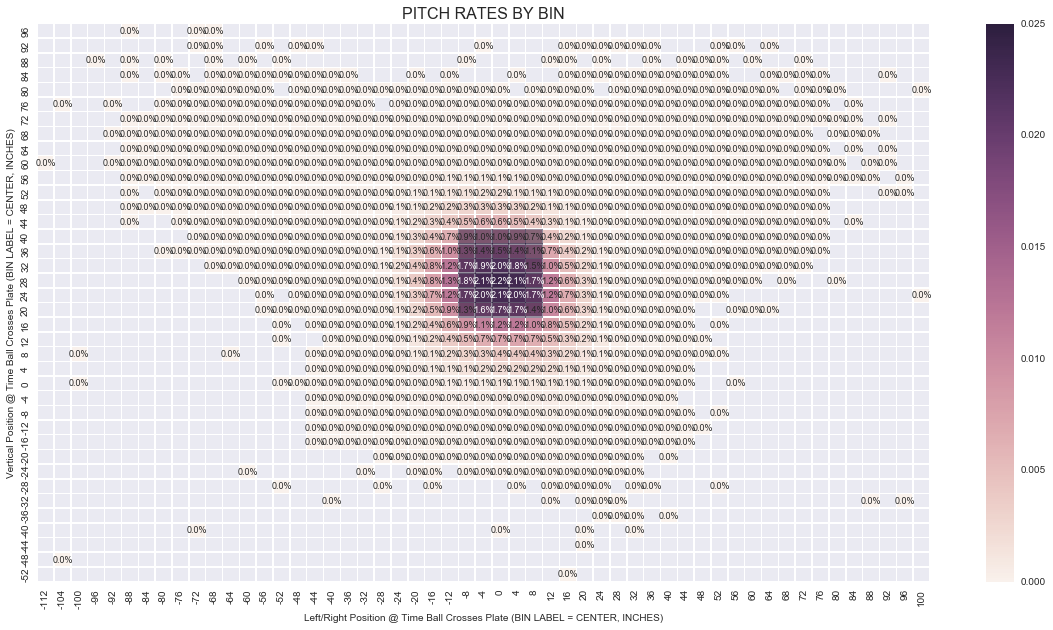

In [21]:
#Prep heatmap size. Must be done outside of sns.heatmap().
pitch_loc_dims = (20, 10)
fig, ax = plt.subplots(figsize=pitch_loc_dims)

#Set up Pivottable with PITCH RATES BY LOCATION BIN
pitch_loc_rates = pd.pivot_table(df, values='percent_in_bin', index=['pz_bin'],
            columns=['px_bin'], aggfunc=np.mean)

#Set up Pivottable for whether bin is WITHIN AVG STRIKE ZONE
pitch_loc_sz = pd.pivot_table(df, values='in_sz', index=['pz_bin'],
            columns=['px_bin'], aggfunc=np.mean)

#Show heatmap of PITCH RATES BY BIN
sns.heatmap(pitch_loc_rates, annot=True, annot_kws={"size": 9}, fmt=".1%", linewidths=.5,
            cbar=True, linecolor = "white", alpha= 1.0, vmin=0, vmax=0.025).invert_yaxis()

#Show heatmap for AVERAGE STRIKE ZONE SIZE as overlay; use ALPHA to set transparency
sns.heatmap(pitch_loc_sz, annot = False, alpha=0.5, mask = pitch_loc_sz <1,cbar=False,vmin=0, vmax=1).invert_yaxis()

#SET TITLES, AXIS-LABELS. Must be done outside of sns.heatmap().
sns.plt.title('PITCH RATES BY BIN', fontsize=16)
sns.plt.xlabel("Left/Right Position @ Time Ball Crosses Plate (BIN LABEL = CENTER, INCHES)",fontsize=10)
sns.plt.ylabel("Vertical Position @ Time Ball Crosses Plate (BIN LABEL = CENTER, INCHES)",fontsize=10)

- Takeaway from above exploratory heatmap: While there is a very wide range of locations of when the ball crosses the strike zone, the vast majority of pitches are within 4 bins (16 inches) of the strike zone.

### Set up initial exploratory heatmap; % of pitches by location:

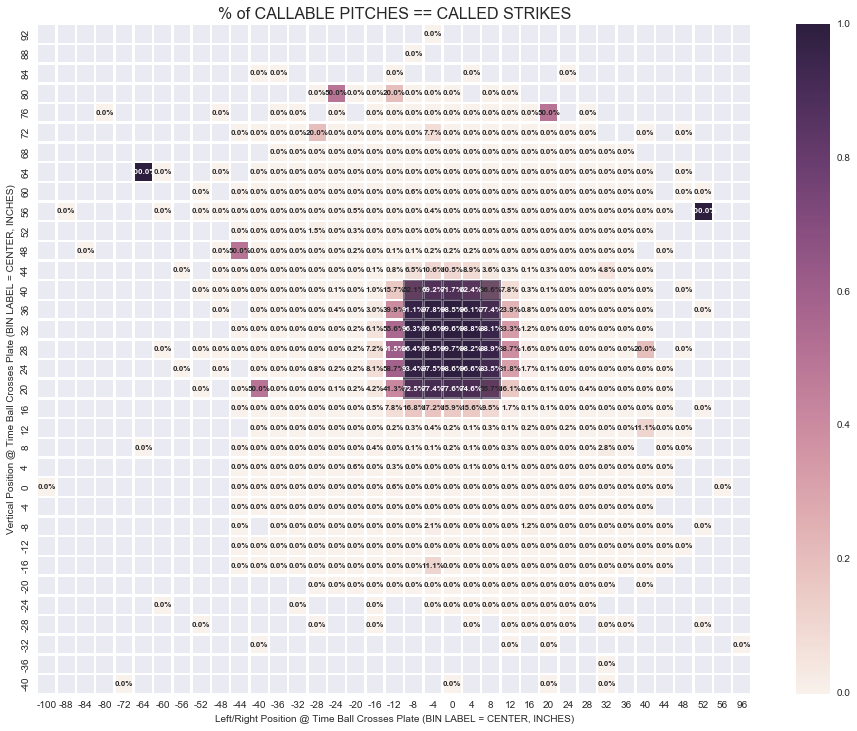

In [22]:
#Set up Pivottable with CALLED STRIKE RATE (AS % of CALLABLE PITCHES)
pitch_called_strike_rates = pd.pivot_table(df[(df['callable'] == 1)], values='called_strike', index=['pz_bin'],
            columns=['px_bin'], aggfunc=np.mean)

#Set up Pivottable for whether bin is WITHIN AVG STRIKE ZONE... note that size of Pivot MUST MATCH to create overlay
pitch_loc_callable = pd.pivot_table(df[(df['callable'] == 1)], values='in_sz', index=['pz_bin'],
            columns=['px_bin'], aggfunc=np.mean)

#Size heatmap.
pitch_loc_dims = (16, 12)
fig, ax = plt.subplots(figsize=pitch_loc_dims)

#Show heatmap of CALLED STRIKE RATES (AS % OF CALLABLE PITCHES) BY BIN
sns.heatmap(pitch_called_strike_rates, annot=True, annot_kws={"size": 8, "fontweight" : "bold"}, fmt=".1%", linewidths=1.5,
            cbar=True, linecolor = "white", alpha= 1.0, vmin=0, vmax=1).invert_yaxis()

#Show heatmap for AVERAGE STRIKE ZONE SIZE as overlay; use ALPHA to set transparency
sns.heatmap(pitch_loc_callable, annot = False, alpha=0.6,mask = pitch_loc_callable <1,cbar=False, vmin=0, vmax=1).invert_yaxis()

#SET TITLE
sns.plt.title('% of CALLABLE PITCHES == CALLED STRIKES',fontsize=16)
sns.plt.xlabel("Left/Right Position @ Time Ball Crosses Plate (BIN LABEL = CENTER, INCHES)",fontsize=10)
sns.plt.ylabel("Vertical Position @ Time Ball Crosses Plate (BIN LABEL = CENTER, INCHES)",fontsize=10)

- Takeaway from above heatmap: It is exceedingly rare for an umpire to call a strike more than 2 bins (8 inches) outside of the average strike zone; as such, we can focus all analysis within this reduced location bin area.

### Set up STANDARDIZED reduced location bin heatmap on % of CALLED STRIKES on CALLABLE PITCHES:

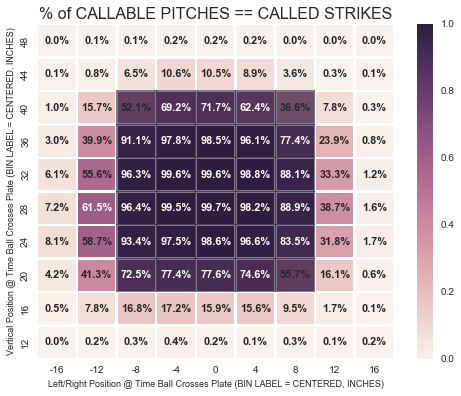

In [23]:
#Set up Pivottable with CALLED STRIKE RATE (AS % of CALLABLE PITCHES) on REDUCED BINS
pitch_called_strike_rates_reducedbins = pd.pivot_table(df[(df['callable'] == 1) &
                                                        (df['px_bin'] <= 16) & (df['px_bin'] >= -16) &
                                                        (df['pz_bin'] <= 48) & (df['pz_bin'] >= 12)], 
                                                     values='called_strike', index=['pz_bin'],
                                                     columns=['px_bin'], aggfunc=np.mean)

#Set up Pivottable for whether bin is WITHIN AVG STRIKE ZONE... Will be re-used each consistently-sized heatmap.
pitch_loc_sz_reducedbins = pd.pivot_table(df[(df['callable'] == 1) & 
                                           (df['px_bin'] <= 16) & (df['px_bin'] >= -16) &
                                           (df['pz_bin'] <= 48) & (df['pz_bin'] >= 12)], 
                                        values='in_sz', index=['pz_bin'],columns=['px_bin'], aggfunc=np.mean)

#Size heatmap.
pitch_loc_dims = (8, 6)
fig, ax = plt.subplots(figsize=pitch_loc_dims)

#Show heatmap of CALLED STRIKE RATES BY BIN
sns.heatmap(pitch_called_strike_rates_reducedbins, annot=True, annot_kws={"size": 11, "fontweight" : "bold"}, fmt=".1%", linewidths=1.5,
            cbar=True, linecolor = "white", alpha= 1.0, vmin=0, vmax=1).invert_yaxis()

#Show heatmap for AVERAGE STRIKE ZONE SIZE as overlay
sns.heatmap(pitch_loc_sz_reducedbins, annot = False, alpha=0.6,mask = pitch_loc_sz_reducedbins <1,cbar=False, vmin=0, vmax=1).invert_yaxis()

#SET TITLES
sns.plt.title('% of CALLABLE PITCHES == CALLED STRIKES',fontsize=16)
sns.plt.xlabel("Left/Right Position @ Time Ball Crosses Plate (BIN LABEL = CENTERED, INCHES)",fontsize=9)
sns.plt.ylabel("Vertical Position @ Time Ball Crosses Plate (BIN LABEL = CENTERED, INCHES)",fontsize=9)

- Each of the above boxes represents the % of callable pitches that get called as strikes. For example, you would read the bin at the bottom-left corner of the strike zone (dark grey box) as "As a % of callable pitches, the average called strike rate in the bottom-left corner of the strike zone is 72.5% (72.5 strikes per 100 callable pitches)


- Now that we have set up our initial standardized heatmap, we would like to explore the theory that an umpire may be biased towards the home team in making strike calls. As such, we will set up Heat maps each for the home team, away team, and difference between the two.

### % of CALLED STRIKES on CALLABLE PITCHES for HOME TEAM:

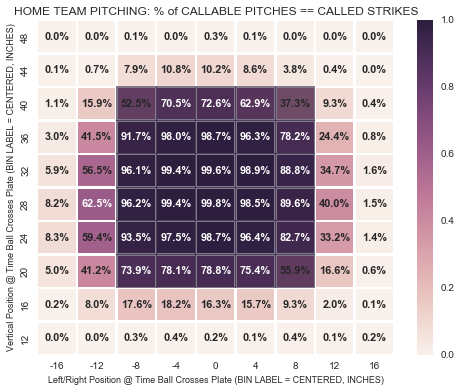

In [24]:
#Set up Pivottable with CALLED STRIKE RATE (AS % of CALLABLE PITCHES) on REDUCED BINS for HOME TEAM
pitch_called_strike_rates_reducedbins_home = pd.pivot_table(df[(df['callable'] == 1) &
                                                        (df['px_bin'] <= 16) & (df['px_bin'] >= -16) &
                                                        (df['pz_bin'] <= 48) & (df['pz_bin'] >= 12) &
                                                        (df['inning_topbot'] == 'top')], 
                                                     values='called_strike', index=['pz_bin'],
                                                     columns=['px_bin'], aggfunc=np.mean)

#Size heatmap.
pitch_loc_dims = (8, 6)
fig, ax = plt.subplots(figsize=pitch_loc_dims)

#Show heatmap of CALLED STRIKE RATES BY BIN for HOME TEAM
sns.heatmap(pitch_called_strike_rates_reducedbins_home, annot=True, annot_kws={"size": 11, "fontweight" : "bold"}, fmt=".1%", linewidths=1.5,
            cbar=True, linecolor = "white", alpha= 1.0, vmin=0, vmax=1).invert_yaxis()

#Show heatmap for AVERAGE STRIKE ZONE SIZE as overlay
sns.heatmap(pitch_loc_sz_reducedbins, annot = False, alpha=0.6,mask = pitch_loc_sz_reducedbins <1,cbar=False, vmin=0, vmax=1).invert_yaxis()

#SET TITLES
sns.plt.title('HOME TEAM PITCHING: % of CALLABLE PITCHES == CALLED STRIKES',fontsize=12)
sns.plt.xlabel("Left/Right Position @ Time Ball Crosses Plate (BIN LABEL = CENTERED, INCHES)",fontsize=9)
sns.plt.ylabel("Vertical Position @ Time Ball Crosses Plate (BIN LABEL = CENTERED, INCHES)",fontsize=9)

- This gives a clear picture of called strike rates on callable pitches by location bin for the Home team. Now, let's compare to the away team...

### % of CALLED STRIKES on CALLABLE PITCHES for AWAY TEAM:

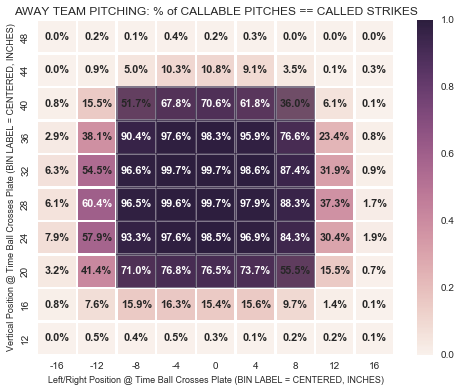

In [26]:
#Set up Pivottable with CALLED STRIKE RATE (AS % of CALLABLE PITCHES) on REDUCED BINS for AWAY TEAM
pitch_called_strike_rates_reducedbins_away = pd.pivot_table(df[(df['callable'] == 1) &
                                                        (df['px_bin'] <= 16) & (df['px_bin'] >= -16) &
                                                        (df['pz_bin'] <= 48) & (df['pz_bin'] >= 12) &
                                                        (df['inning_topbot'] == 'bot')], 
                                                     values='called_strike', index=['pz_bin'],
                                                     columns=['px_bin'], aggfunc=np.mean)

#Size heatmap.
pitch_loc_dims = (8, 6)
fig, ax = plt.subplots(figsize=pitch_loc_dims)

#Show heatmap of CALLED STRIKE RATES BY BIN for AWAY TEAM
sns.heatmap(pitch_called_strike_rates_reducedbins_away, annot=True, annot_kws={"size": 11, "fontweight" : "bold"}, fmt=".1%", linewidths=1.5,
            cbar=True, linecolor = "white", alpha= 1.0, vmin=0, vmax=1).invert_yaxis()

#Show heatmap for AVERAGE STRIKE ZONE SIZE as overlay
sns.heatmap(pitch_loc_sz_reducedbins, annot = False, alpha=0.6,mask = pitch_loc_sz_reducedbins <1,cbar=False, vmin=0, vmax=1).invert_yaxis()

#SET TITLES
sns.plt.title('AWAY TEAM PITCHING: % of CALLABLE PITCHES == CALLED STRIKES',fontsize=12)
sns.plt.xlabel("Left/Right Position @ Time Ball Crosses Plate (BIN LABEL = CENTERED, INCHES)",fontsize=9)
sns.plt.ylabel("Vertical Position @ Time Ball Crosses Plate (BIN LABEL = CENTERED, INCHES)",fontsize=9)

- It seems that many bins have a lower called strike rate when the away team is pitching! To be certain, let's create a heat map in the next section based purely on the differences between home and away rates.

### Heatmap on % of called strikes on callable pitches; DIFFERENCES HOME v. AWAY TEAM:

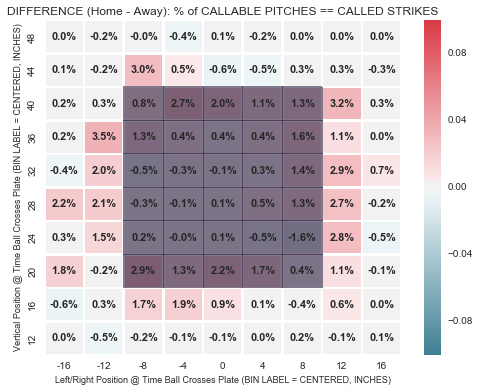

In [27]:
#Set up Pivottable with CALLED STRIKE RATE (AS % of CALLABLE PITCHES) on REDUCED BINS on HOME/AWAY DIFFERENCES
pitch_called_strike_rates_reducedbins_diff = pitch_called_strike_rates_reducedbins_home - pitch_called_strike_rates_reducedbins_away

#Re-size heatmap
pitch_loc_dims = (8, 6)
fig, ax = plt.subplots(figsize=pitch_loc_dims)

#Show heatmap of CALLED STRIKE RATES BY BIN for HOME v. AWAY differences. Note modified color palette.
sns.heatmap(pitch_called_strike_rates_reducedbins_diff, annot=True, annot_kws={"size": 11, "fontweight" : "bold"}, fmt=".1%", linewidths=1.5,
            cbar=True, linecolor = "white", alpha= 1.0, vmin=-0.1, vmax=0.1,
            cmap = sns.diverging_palette(220, 10, as_cmap=True)).invert_yaxis()

#Show heatmap for AVERAGE STRIKE ZONE SIZE as overlay
sns.heatmap(pitch_loc_sz_reducedbins, annot = False, alpha=0.6,mask = pitch_loc_sz_reducedbins <1,cbar=False, vmin=0, vmax=1).invert_yaxis()

#SET TITLES
sns.plt.title('DIFFERENCE (Home - Away): % of CALLABLE PITCHES == CALLED STRIKES',fontsize=12)
sns.plt.xlabel("Left/Right Position @ Time Ball Crosses Plate (BIN LABEL = CENTERED, INCHES)",fontsize=9)
sns.plt.ylabel("Vertical Position @ Time Ball Crosses Plate (BIN LABEL = CENTERED, INCHES)",fontsize=9)

- Wow! This shows a clear bias towards the home team. Note how many more "red" bins there are than "blue" bins, indicating an advantage for the home team.
- As example, you would read the bin at the top-right corner of the strike zone (dark grey box) as "As a % of callable pitches, the average called strike rate in the top-right corner of the strike zone is 1.3% more for the home team than the away team (1.3 strikes per 100 callable pitches)

- To give more than just visual evidence by bin, we will get to a more precise measure of weighted-average advantage by bin location grouping in the next section.

### DETERMINE WEIGHTED IMPACT BY EACH ZONE_CATEGORY: HOME v. AWAY:
- In the next section, we will create a methodology to group location bins by location CATEGORY, and calculate the impact per category on a weighted-average methodology by total pitches by bin.

In [28]:
"""The following function will be used to compare dataframes containing information on differences in
called strike rates by bin"""

def print_key_stats (dataframe):
    """PRINTS KEY STATISTICS BY ZONE CATEGORY SET UP FOR BINS"""
    stats_dict = dict(dataframe['weighted_mean_count'].groupby(level=0, group_keys=False).sum()/dataframe['combined_count'].groupby(level=0, group_keys=False).sum())
    print("VARIANCE BY BIN LOCATION CATEGORY:\n"
        "Inner Strike Zone Bins:         "+'{:.1%}'.format(stats_dict['SZ: INNER BINS'])+"\n"
        "Within Outer Strike Zone Bins:  "+'{:.1%}'.format(stats_dict['SZ: OUTER BINS'])+"\n"
        "1 Bin Outside Strike Zone:      "+'{:.1%}'.format(stats_dict['NOT_SZ: 1 OUTSIDE SZ'])+"\n"
        "2 Bins Outside Strike Zone:     "+'{:.1%}'.format(stats_dict['NOT_SZ: 2 OUTSIDE SZ'])+"\n"
        "3+ Bins Outside Strike Zone:    "+'{:.1%}'.format(stats_dict['NOT_SZ: 3+ OUTSIDE SZ'])+"\n"
          )

In [29]:
"""Note that to get to average impact by pitch, it is crucial that differences are first aggregated on
a bin-by-bin basis in order to capture umpire impact.

The following re-calculates the differences by individual bin, then re-aggregates differences
within the greater "zone_category" on a weighted-average basis by bin."""


"""TO RE-USE FOR OTHER ANALYSIS, MODIFY WITH THE FOLLOWING STEPS"""

#1) CALCULATE AVERAGE DIFFERENCE IN % CALLED STRIKES BY BIN COMBO
diffs_home_away = (
    df[(df['callable'] == 1)&(df['inning_topbot'] == 'top')].groupby(
    ['zone_category', 'px_pz_bin_combo']).agg({'called_strike': [np.mean]}) -
    df[(df['callable'] == 1)&(df['inning_topbot'] == 'bot')].groupby(
    ['zone_category', 'px_pz_bin_combo']).agg({'called_strike': [np.mean]}))

#2) ADD COUNT OF TARGET OF ANALYSIS
#if comparing two different sizes, pick SMALLER data set as target (like indiv umpire) to not skew the weighted results.
diffs_home_away['combined_count'] = df[(df['callable'] == 1)&(df['inning_topbot'] == 'top')].groupby(
    ['zone_category', 'px_pz_bin_combo']).agg({'called_strike': [len]})

#3) CALCULATE TOTAL (COMBINED) COUNT IN BIN AND ADD TO DATAFRAME
diffs_home_away['weighted_mean_count'] = diffs_home_away['called_strike']['mean']*diffs_home_away['combined_count']
# 3.5) Re-display the following if needed to diagnose number of pitches, weighted averages pulled in
# display(diffs_home_away.head())
diffs_home_away['combined_count'].groupby(level=0, group_keys=False).sum()

#4) call key stats function to print comparison of each bin zone category
print("On a weighted average basis by individual location bin, \n"
      "the Home Team pitcher gets the following additional rate of called strikes by zone location:\n")
print_key_stats(diffs_home_away)

On a weighted average basis by individual location bin, 
the Home Team pitcher gets the following additional rate of called strikes by zone location:

VARIANCE BY BIN LOCATION CATEGORY:
Inner Strike Zone Bins:         0.1%
Within Outer Strike Zone Bins:  1.0%
1 Bin Outside Strike Zone:      1.3%
2 Bins Outside Strike Zone:     0.1%
3+ Bins Outside Strike Zone:    -0.0%



- Takeaway: The trends seen in the visual bin analysis hold when we calculate actual impact by bin location. The average impact by bin location is especially large within the outer bins of the strike zone and one bin outside of the strike zone; there is a +1.0% called strike rate advantage in the outer bins of the strike zone and a +1.3% advantage one bin outside of the strike zone for the home team!
<br>

## Next, we will explore of home/away advantage on a 2-strike count
- Theory: A home pitching advantage due to umpire would be largest on a with two strikes, when the umpire is most likely to feel the pressure of the crowd.

### % of CALLED STRIKES on CALLABLE PITCHES for HOME TEAM with 2-strike COUNT:

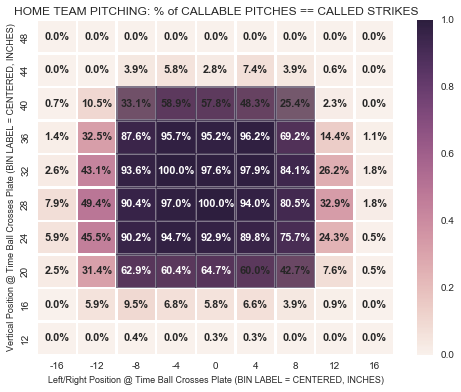

In [30]:
#Set up Pivottable with CALLED STRIKE RATE (AS % of CALLABLE PITCHES) on REDUCED BINS for HOME TEAM
pitch_called_strike_rates_reducedbins_home_2str = pd.pivot_table(df[(df['callable'] == 1) &
                                                        (df['px_bin'] <= 16) & (df['px_bin'] >= -16) &
                                                        (df['pz_bin'] <= 48) & (df['pz_bin'] >= 12) &
                                                        (df['inning_topbot'] == 'top') & (df['strikes'] == 2)], 
                                                     values='called_strike', index=['pz_bin'],
                                                     columns=['px_bin'], aggfunc=np.mean)

#Size heatmap.
pitch_loc_dims = (8, 6)
fig, ax = plt.subplots(figsize=pitch_loc_dims)

#Show heatmap of CALLED STRIKE RATES BY BIN for HOME TEAM
sns.heatmap(pitch_called_strike_rates_reducedbins_home_2str, annot=True, annot_kws={"size": 11, "fontweight" : "bold"}, fmt=".1%", linewidths=1.5,
            cbar=True, linecolor = "white", alpha= 1.0, vmin=0, vmax=1).invert_yaxis()

#Show heatmap for AVERAGE STRIKE ZONE SIZE as overlay
sns.heatmap(pitch_loc_sz_reducedbins, annot = False, alpha=0.6,mask = pitch_loc_sz_reducedbins <1,cbar=False, vmin=0, vmax=1).invert_yaxis()

#SET TITLES
sns.plt.title('HOME TEAM PITCHING: % of CALLABLE PITCHES == CALLED STRIKES',fontsize=12)
sns.plt.xlabel("Left/Right Position @ Time Ball Crosses Plate (BIN LABEL = CENTERED, INCHES)",fontsize=9)
sns.plt.ylabel("Vertical Position @ Time Ball Crosses Plate (BIN LABEL = CENTERED, INCHES)",fontsize=9)

### % of CALLED STRIKES on CALLABLE PITCHES for AWAY TEAM with 2-strike COUNT:

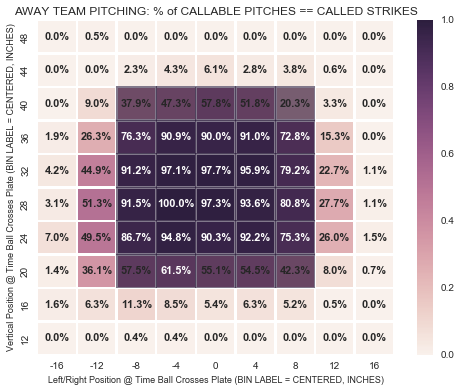

In [31]:
#Set up Pivottable with CALLED STRIKE RATE (AS % of CALLABLE PITCHES) on REDUCED BINS for AWAY TEAM
pitch_called_strike_rates_reducedbins_away_2str = pd.pivot_table(df[(df['callable'] == 1) &
                                                        (df['px_bin'] <= 16) & (df['px_bin'] >= -16) &
                                                        (df['pz_bin'] <= 48) & (df['pz_bin'] >= 12) &
                                                        (df['inning_topbot'] == 'bot') & (df['strikes'] == 2)], 
                                                     values='called_strike', index=['pz_bin'],
                                                     columns=['px_bin'], aggfunc=np.mean)

#Size heatmap.
pitch_loc_dims = (8, 6)
fig, ax = plt.subplots(figsize=pitch_loc_dims)

#Show heatmap of CALLED STRIKE RATES BY BIN for AWAY TEAM
sns.heatmap(pitch_called_strike_rates_reducedbins_away_2str, annot=True, annot_kws={"size": 11, "fontweight" : "bold"}, fmt=".1%", linewidths=1.5,
            cbar=True, linecolor = "white", alpha= 1.0, vmin=0, vmax=1).invert_yaxis()

#Show heatmap for AVERAGE STRIKE ZONE SIZE as overlay
sns.heatmap(pitch_loc_sz_reducedbins, annot = False, alpha=0.6,mask = pitch_loc_sz_reducedbins <1,cbar=False, vmin=0, vmax=1).invert_yaxis()

#SET TITLES
sns.plt.title('AWAY TEAM PITCHING: % of CALLABLE PITCHES == CALLED STRIKES',fontsize=12)
sns.plt.xlabel("Left/Right Position @ Time Ball Crosses Plate (BIN LABEL = CENTERED, INCHES)",fontsize=9)
sns.plt.ylabel("Vertical Position @ Time Ball Crosses Plate (BIN LABEL = CENTERED, INCHES)",fontsize=9)

### % of CALLED STRIKES on CALLABLE PITCHES for DIFFERENCES BETWEEN HOME AND AWAY TEAM with 2-strike COUNT:

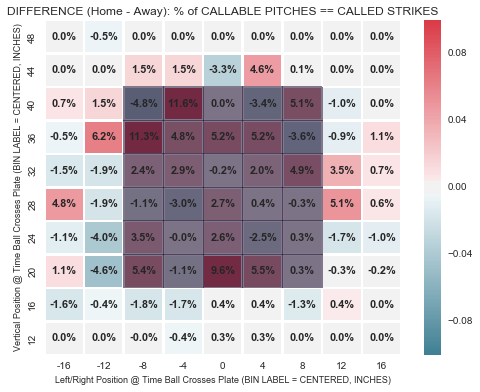

In [32]:
#Set up Pivottable with CALLED STRIKE RATE (AS % of CALLABLE PITCHES) on REDUCED BINS on HOME/AWAY DIFFERENCES
pitch_called_strike_rates_reducedbins_diff_2str = pitch_called_strike_rates_reducedbins_home_2str - pitch_called_strike_rates_reducedbins_away_2str

#Re-size heatmap
pitch_loc_dims = (8, 6)
fig, ax = plt.subplots(figsize=pitch_loc_dims)

#Show heatmap of CALLED STRIKE RATES BY BIN for HOME v. AWAY differences. Note modified color palette.
sns.heatmap(pitch_called_strike_rates_reducedbins_diff_2str, annot=True, annot_kws={"size": 11, "fontweight" : "bold"}, fmt=".1%", linewidths=1.5,
            cbar=True, linecolor = "white", alpha= 1.0, vmin=-0.1, vmax=0.1,
            cmap = sns.diverging_palette(220, 10, as_cmap=True)).invert_yaxis()

#Show heatmap for AVERAGE STRIKE ZONE SIZE as overlay
sns.heatmap(pitch_loc_sz_reducedbins, annot = False, alpha=0.6,mask = pitch_loc_sz_reducedbins <1,cbar=False, vmin=0, vmax=1).invert_yaxis()

#SET TITLES
sns.plt.title('DIFFERENCE (Home - Away): % of CALLABLE PITCHES == CALLED STRIKES',fontsize=12)
sns.plt.xlabel("Left/Right Position @ Time Ball Crosses Plate (BIN LABEL = CENTERED, INCHES)",fontsize=9)
sns.plt.ylabel("Vertical Position @ Time Ball Crosses Plate (BIN LABEL = CENTERED, INCHES)",fontsize=9)

- With two strikes, this shows an slightly larger umpire bias for the home team than on a typical pitch count. Note how many more "red" bins there are than "blue" bins.

### DETERMINE WEIGHTED IMPACT BY EACH ZONE_CATEGORY: HOME v. AWAY with 2-strike COUNT:

In [33]:
"""TO RE-USE FOR OTHER ANALYSIS, MODIFY WITH THE FOLLOWING STEPS"""

#1) CALCULATE AVERAGE DIFFERENCE IN % CALLED STRIKES BY BIN COMBO
diffs_home_away_2str = (
    df[(df['callable'] == 1)&(df['inning_topbot'] == 'top') & (df['strikes'] == 2)].groupby(
    ['zone_category', 'px_pz_bin_combo']).agg({'called_strike': [np.mean]}) -
    df[(df['callable'] == 1)&(df['inning_topbot'] == 'bot') & (df['strikes'] == 2)].groupby(
    ['zone_category', 'px_pz_bin_combo']).agg({'called_strike': [np.mean]}))

#2) ADD COUNT OF TARGET OF ANALYSIS
#if comparing two different sizes, pick SMALLER data set as target (like indiv umpire) to not skew the weighted results.
diffs_home_away_2str['combined_count'] = df[(df['callable'] == 1)&(df['inning_topbot'] == 'top')&
                                            (df['strikes'] == 2)].groupby(
    ['zone_category', 'px_pz_bin_combo']).agg({'called_strike': [len]})

#3) CALCULATE TOTAL (COMBINED) COUNT IN BIN AND ADD TO DATAFRAME
diffs_home_away_2str['weighted_mean_count'] = diffs_home_away_2str['called_strike']['mean']*diffs_home_away_2str['combined_count']
# 3.5) Re-display the following if needed to diagnose number of pitches, weighted averages pulled in
# display(diffs_home_away_2str.head())
diffs_home_away_2str['combined_count'].groupby(level=0, group_keys=False).sum()

#4) call key stats function to print comparison of each bin zone category
print("On a weighted average basis by individual location bin, \n"
      "the Home Team pitcher gets the following additional rate of called strikes by zone location:\n")
print_key_stats(diffs_home_away_2str)

On a weighted average basis by individual location bin, 
the Home Team pitcher gets the following additional rate of called strikes by zone location:

VARIANCE BY BIN LOCATION CATEGORY:
Inner Strike Zone Bins:         1.2%
Within Outer Strike Zone Bins:  2.4%
1 Bin Outside Strike Zone:      -0.1%
2 Bins Outside Strike Zone:     0.1%
3+ Bins Outside Strike Zone:    -0.0%



- Takeaway:  With two strikes, the average impact by bin location is large across multiple sets of bins, especially for any bins within the strike zone. While overall the rates are SLIGHTLY more biased towards the home team when there are TWO STRIKES in the bins within the strike zone compared to home team bias with ANY AMOUNT OF STRIKES within the count, the bias isn't drastic enough to firmly conclude additional umpire bias on two strikes.
<br>

# Relationship between stadium elevation and pitch break

## Magnus Effect

In professional baseball, pitchers put spin the ball at delivery to alter the overall trajectory of the pitch. The change in trajectory is determined mainly by the Magnus effect – a fundamental principle of aerodynamics. This phenomenon states that the rotation of any cylinder or ball causes an angular deflection of the surrounding air depending on the type of spin (e.g. backspin, topspin, and sidespin). Therefore, pitchers vary the spin rate, angle, and overall velocity of the ball to produce over 10 unique pitch types (Fastball, Curveball, Changeup, etc.) that are categorized by their speed and movement along the x and z axes. 

here is a good youtube video explaining the effect: https://www.youtube.com/watch?v=2OSrvzNW9FE

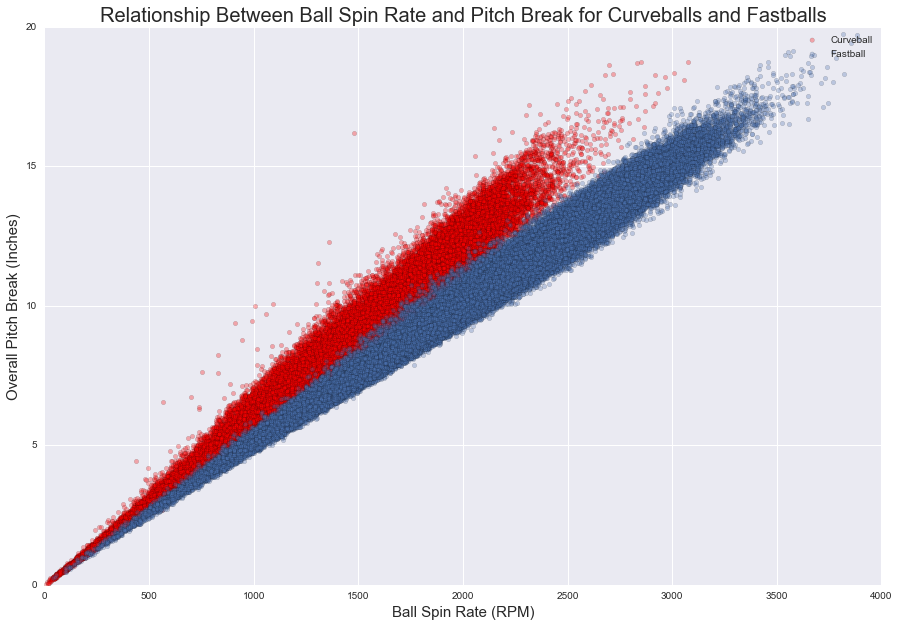

In [69]:
ax1 = df[df.pitch_type == 'CU'].plot(kind = 'scatter', x ='spin_rate', y = 'break_total', color = 'Red', alpha =.3, label = 'Curveball')
#df[df_pitcher.pitch_type == 'SL'].plot(kind = 'scatter', x ='spin_rate', y = 'break_total', color = 'Green', alpha =.3, label = 'Changeup', ax = ax1)
graph = df[within_pitcher.pitch_type == 'FF'].plot(kind = 'scatter', x ='spin_rate', y = 'break_total', ax = ax1, alpha = .3, figsize = (15,10), xlim = (0,4000), label = 'Fastball', ylim = (0,20))
graph.set_ylabel('Overall Pitch Break (Inches)')
graph.set_xlabel('Ball Spin Rate (RPM)')
graph.set_title('Relationship Between Ball Spin Rate and Pitch Break for Curveballs and Fastballs')
graph.title.set_fontsize(20)
graph.xaxis.label.set_fontsize(15)
graph.yaxis.label.set_fontsize(15)
plt.savefig('magnus_effect.png')

## Pitch Types

### Examine pitch types to see what is in the dataset

In [35]:
pitch_type = data.groupby('pitch_type')

counts are identical between x and y movement, which means no missing values between them

also shows us which pitches are most common

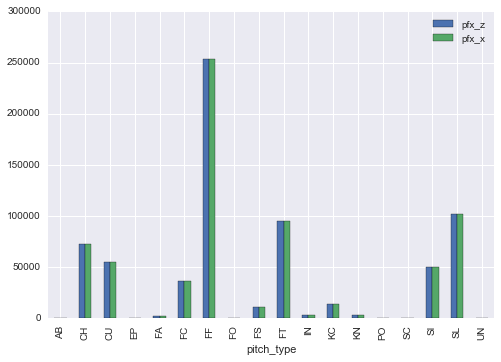

In [36]:
pitch_type['pfx_z','pfx_x'].count().plot(kind = 'bar')

What the pitch abbreviations mean

In [37]:
pitch_legend = pd.read_csv('pitch-key.csv', index_col  = 'Label')
pitch_legend

,Full Name
Label,
AB,Automatic Ball
CH,Changeup
CU,Curveball
EP,Eephus
FA,Fastball
FC,Cutter
FF,Four-seam
FO,Fork Ball
FS,Split Finger


### How pitches break and creating a standardized pitch break variable

Check out the distribution of movement per pitch to identify and outliers

Most pitches are pretty normally distributed except for the ones that didnt occur very often

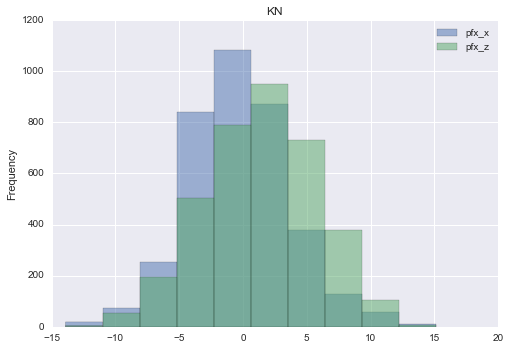

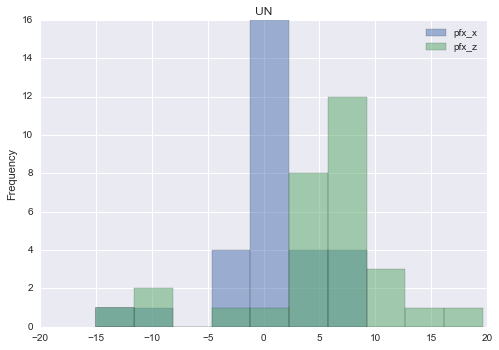

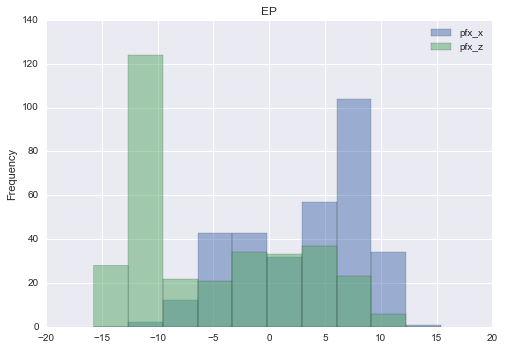

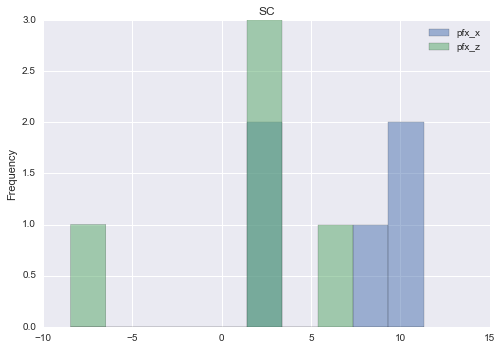

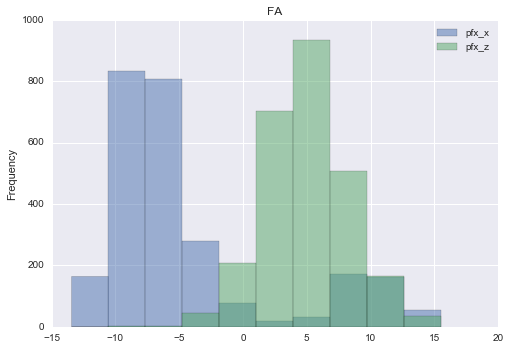

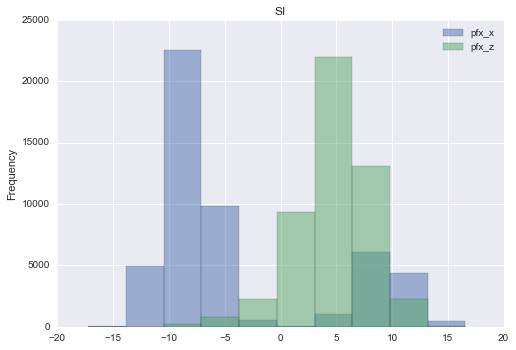

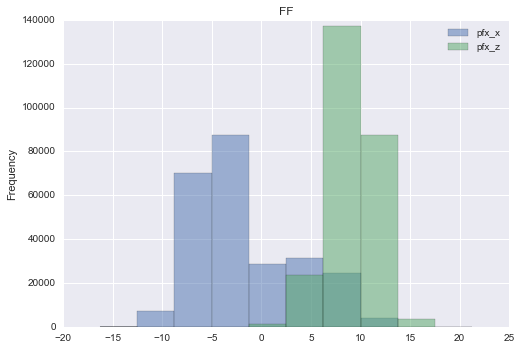

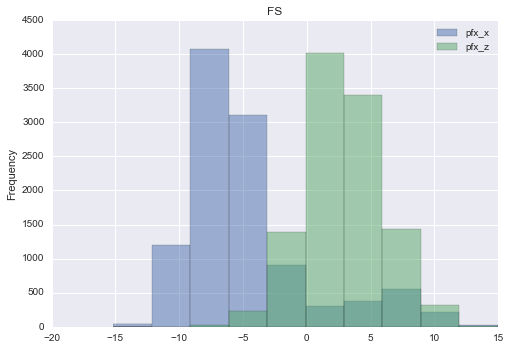

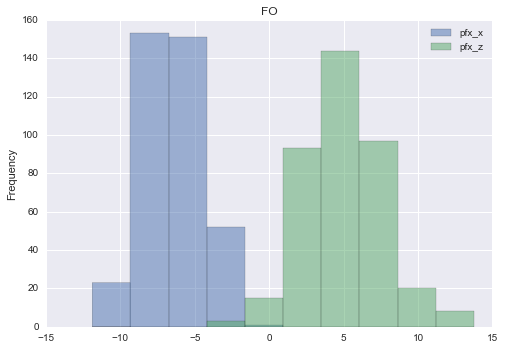

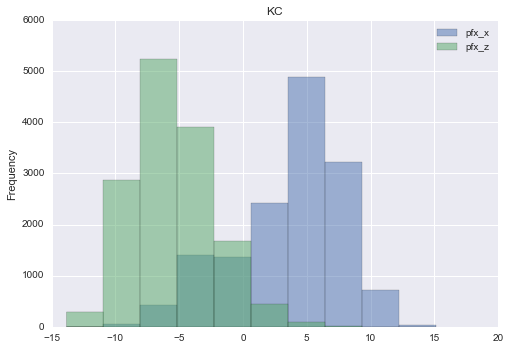

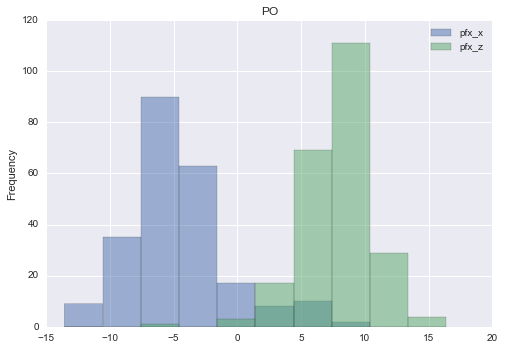

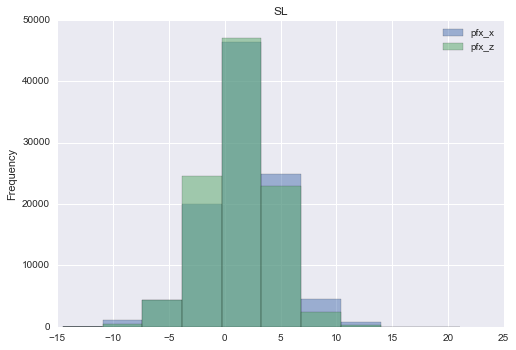

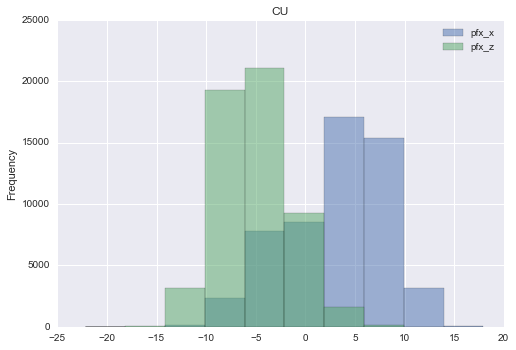

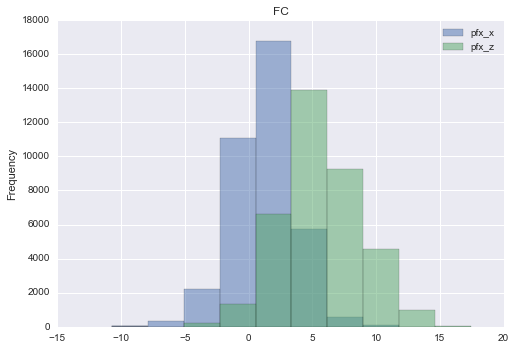

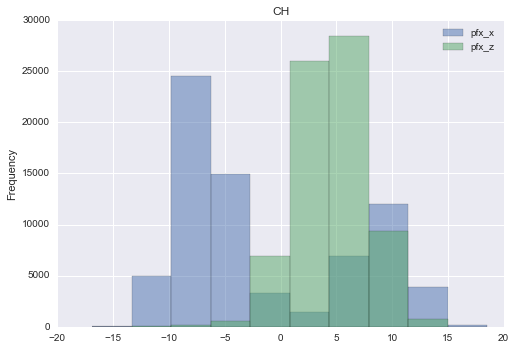

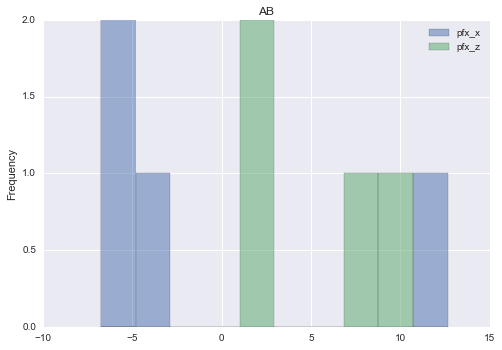

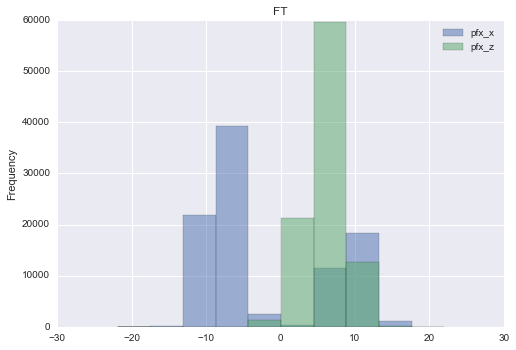

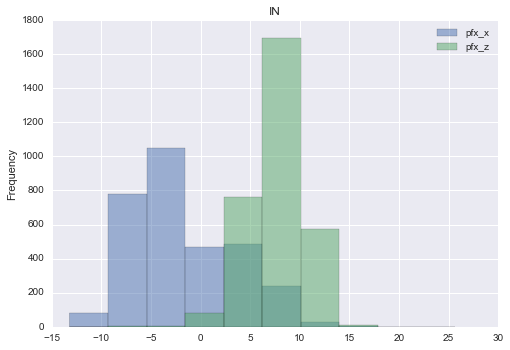

In [38]:
for pitch in pitch_type.groups:
    pitch_type.get_group(pitch)[['pfx_x','pfx_z']].plot(kind = 'hist', title = pitch, alpha =.5)

Tested to see if i could use the agg function to find std and mean for pitch break by every pitch and pitch

In [39]:
df.groupby(['player_id','pitch_type']).agg({'pfx_x':[np.mean, np.std], 'pfx_z':[np.mean, np.std], 'break_total':[np.mean, np.std]})

pfx_x                pfx_z           break_total  \
                           mean       std       mean       std        mean   
player_id pitch_type                                                         
112526    CH          -7.698808  1.494833   4.788593  1.956415    9.252380   
          FF          -4.104136  1.675472   8.982479  1.596970   10.017574   
          FT          -9.033512  1.564678   4.472828  1.656674   10.219555   
          IN          -3.501150  2.207400   7.812600  1.686611    8.720315   
          SL           1.026922  2.147793   2.056728  2.551438    3.461716   
115629    CH          -6.787628  2.151155   5.762744  1.703919    9.084496   
          CU           3.420000  3.054325  -4.843333  1.155610    6.194735   
          FF          -7.337318  1.783834   7.628788  1.781171   10.758742   
          FT          -9.107250  1.023260   3.383000  2.562835    9.887418   
          IN          -4.485000  0.647614   3.476333  1.158768    5.770320   
          SL           0.950954  1.826793   4.324885  1.479384    4.819176   
136600    CH           9.102250  1.549985   6.140750  1.569312   11.116677   
          CU          -6.383000  2.086193  -5.925400  1.645565    8.881121   
          EP          -8.346500  3.766758  -8.070500  0.267993   11.740154   
          FF           7.412000       NaN  12.926000       NaN   14.900309   
          IN           6.340000  0.745788   7.987500  0.873017   10.222365   
          SI          10.745094  2.352393   7.595774  1.908888   13.330846   
          SL           0.643162  1.770324   3.979216  1.476782    4.424420   
150116    CH           7.810884  1.554417   5.673333  1.448130    9.756701   
          CU          -4.014423  1.529621  -7.853124  1.684407    8.938957   
          FC          -1.276667  1.145161   4.158095  1.529074    4.523479   
          FF           4.475645  1.147603   9.681430  1.182974   10.720230   
          FT           8.149293  1.349006   7.629183  1.348679   11.247045   
          IN           3.635000  0.259551   9.775000  0.951998   10.434291   
          SL          -1.731646  1.251911   2.754977  1.620244    3.616222   
150274    FT          -9.980000       NaN   5.860000       NaN   11.573245   
          SL           1.226667  1.234274   2.293333  1.150232    2.709569   
150302    CH          -6.515683  2.427814   1.624335  2.302250    7.200130   
          IN          -6.516250  1.750828   4.848750  1.351226    8.315334   
          PO          -7.205000  0.544472   9.020000  1.004092   11.545249   
...                         ...       ...        ...       ...         ...   
628333    UN           7.228000       NaN -15.055000       NaN   16.700210   
628452    CH          -7.666650  2.089368   1.750299  2.027525    8.191676   
          CU           8.156000  2.247726  -0.979000  1.412873    8.354291   
          FC          -3.853333  1.812850   9.378333  1.197822   10.267766   
          FF          -5.470003  1.934793   7.728843  1.927868    9.671484   
          FT          -8.860000  0.944219   5.494000  1.422262   10.492678   
          SI          -9.179117  1.777020   4.110843  2.229945   10.290412   
          SL           6.308870  1.934387  -0.859156  1.910500    6.658207   
641490    CH          11.233846  1.533582  -0.294462  1.789663   11.380760   
          FF          10.072090  1.549343   5.551886  1.459786   11.613948   
          FT          10.220000  1.286934   2.210000  0.141421   10.460269   
          SL          -1.093154  1.319188  -2.979615  1.282513    3.438369   
641627    CH          -9.493000  0.558186   1.874800  1.076858    9.724222   
          CU           5.997535  2.133145  -6.662667  1.569776    9.199096   
          FF          -9.548672  1.381845   4.511890  1.667563   10.688242   
          FT         -10.740000       NaN   3.460000       NaN   11.283581   
          IN          -5.312000  0.957494   8.678000  1.587323   10.234643   
643327    CH          -3.782618  2.284396   0.44

Moved what I did above into a function, which will then be applied to the main data set

Create within pitcher and within pitch type mean and std movement

In [40]:
def avg_movement(dataframe):
    dataframe['x_avg'] = dataframe.pfx_x.mean()
    dataframe['z_avg'] = dataframe.pfx_z.mean()
    dataframe['break_avg'] = dataframe.break_total.mean()
    dataframe['x_std'] = dataframe.pfx_x.std()
    dataframe['z_std'] = dataframe.pfx_z.std()
    dataframe['break_std'] = dataframe.break_total.std()
    return dataframe

In [41]:
within_pitcher = df.groupby(['player_id','pitch_type']).apply(avg_movement)

In [42]:
# hastag success
within_pitcher.head(5)

,name,player_id,pitch_type,pitch_result,atbat_result,start_speed,z0,x0,pfx_x,pfx_z,px,pz,break_angle,break_length,spin_rate,spin_dir,zone,balls,strikes,outs,play,game_date,inning,inning_topbot,tfs,tfs_zulu,catcher,umpire,umpire_name,stolen_base_attempt,stolen_base_success,batted_ball_type,Unnamed: 32,angle,batted_ball_velocity,direction,hc_x,hc_y,pitch_id,distance_feet,stadium,station,tempF,relhum,altibarom,isclosable,localbarom,altitude,break_total,count,callable,called_strike,called_ball,px_bin,pz_bin,px_pz_bin_combo,in_sz,percent_in_bin,zone_category,x_avg,z_avg,break_avg,x_std,z_std,break_std
0,Eric Stults,445590,FF,"In play, out(s)",Pop Out,86.3,70.800,17.904,10.469,4.975,8.652,31.932,-32.4,7.4,2142.607,115.621,14.0,2,0,2,John Mayberry Jr. pops out to first baseman ...,2015-04-10,1,top,5515,2015-04-11T00:55:15Z,542194,427454,Paul Schrieber,0,0,PU,NaN,NaN,NaN,NaN,169.45,188.98,21,NaN,braves,KATL,66.4,87.4,30.038,False,28.988,1050,11.590970,1,0,0,0,8,32,"8, 32",1,0.014757,SZ: OUTER BINS,6.709900,9.013859,11.38987,1.440968,1.694477,1.216115
1,Eric Stults,445590,FF,Ball,Flyout,90.5,73.560,11.544,7.828,10.677,-3.912,42.804,-41.4,4.3,2567.990,143.861,11.0,2,2,0,Curtis Granderson flies out to center fielder ...,2015-04-10,1,top,5244,2015-04-11T00:52:44Z,542194,427454,Paul Schrieber,0,0,NaN,NaN,0.0,86.0,NaN,122.53,79.95,7,318.0,braves,KATL,66.4,87.4,30.038,False,28.988,1050,13.239181,1,1,0,1,-4,44,"-4, 44",0,0.005998,NOT_SZ: 1 OUTSIDE SZ,6.709900,9.013859,11.38987,1.440968,1.694477,1.216115
2,Eric Stults,445590,FT,Ball,Pop Out,85.2,70.164,15.348,10.113,5.444,0.504,16.812,-30.8,7.4,2107.298,118.500,14.0,0,0,2,John Mayberry Jr. pops out to first baseman ...,2015-04-10,1,top,5450,2015-04-11T00:54:50Z,542194,427454,Paul Schrieber,0,0,NaN,NaN,NaN,NaN,NaN,169.45,188.98,19,NaN,braves,KATL,66.4,87.4,30.038,False,28.988,1050,11.485204,1,1,0,1,0,16,"0, 16",0,0.012191,NOT_SZ: 1 OUTSIDE SZ,8.631813,6.166458,10.73271,1.278618,1.710723,1.369594
3,Eric Stults,445590,FF,Called Strike,Flyout,87.8,72.384,15.096,5.431,9.408,-0.420,27.492,-24.3,4.7,2051.739,150.122,5.0,0,0,0,Curtis Granderson flies out to center fielder ...,2015-04-10,1,top,5142,2015-04-11T00:51:42Z,542194,427454,Paul Schrieber,0,0,NaN,NaN,0.0,86.0,NaN,122.53,79.95,3,318.0,braves,KATL,66.4,87.4,30.038,False,28.988,1050,10.863067,1,1,1,0,0,28,"0, 28",1,0.022422,SZ: INNER BINS,6.709900,9.013859,11.38987,1.440968,1.694477,1.216115
4,Eric Stults,445590,FF,Called Strike,Lineout,88.4,71.988,15.768,7.346,10.306,11.808,28.632,-36.2,4.8,2403.872,144.632,14.0,1,0,1,David Wright lines out to third baseman Chris ...,2015-04-10,1,top,5350,2015-04-11T00:53:50Z,542194,427454,Paul Schrieber,0,0,NaN,NaN,0.0,106.0,NaN,105.97,170.81,13,0.0,braves,KATL,66.4,87.4,30.038,False,28.988,1050,12.656119,1,1,1,0,12,28,"12, 28",0,0.011645,NOT_SZ: 1 OUTSIDE SZ,6.709900,9.013859,11.38987,1.440968,1.694477,1.216115


#### create z score for pitch movement

In [43]:
within_pitcher['x_zscore'] = (within_pitcher.pfx_x - within_pitcher.x_avg) / within_pitcher.x_std
within_pitcher['z_zscore'] = (within_pitcher.pfx_z - within_pitcher.z_avg) / within_pitcher.z_std
within_pitcher['break_zscore'] = (within_pitcher.break_total - within_pitcher.break_avg) / within_pitcher.break_std

looked at the relationship between absolute z score and break total
Started to realize that absolute zscore was stupid

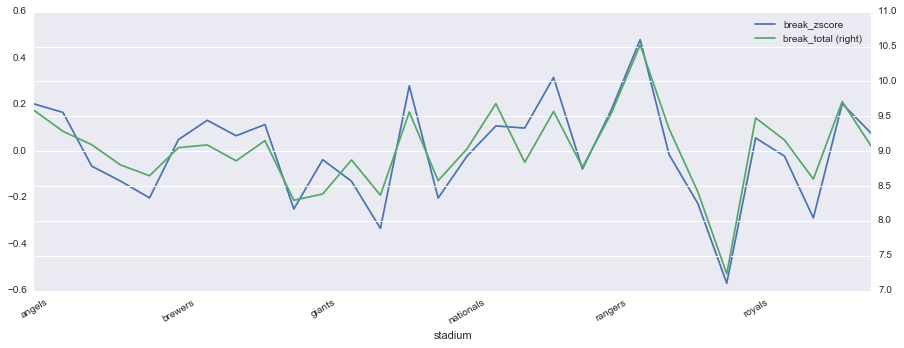

In [44]:
within_pitcher.groupby('stadium')[['break_zscore', 'break_total']].mean().plot(secondary_y = ['break_total'], rot = 30, figsize = (15,5))

I was curious how the distribution changed for a given pitch when it was standardized for pitcher

This is a knuckle curve (definitely normalized the distribution:

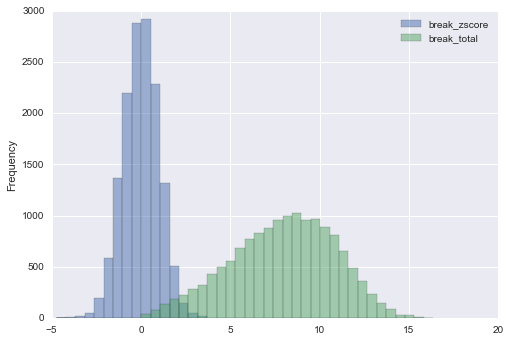

In [45]:
within_pitcher[within_pitcher.pitch_type == 'KC'][['break_zscore', 'break_total']].plot(kind = 'hist', alpha = .5, bins = 40)

## Stadium and break zscore

### Since zscore for pitch and pitch type worked, look at between effects of stadiums

made a new df in which the rows are the stadium
and plotted the mean break by stadium. Results look promising regarding hypothesis: Colorado Rockies had least amount of break.

/Users/pyvarjan/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


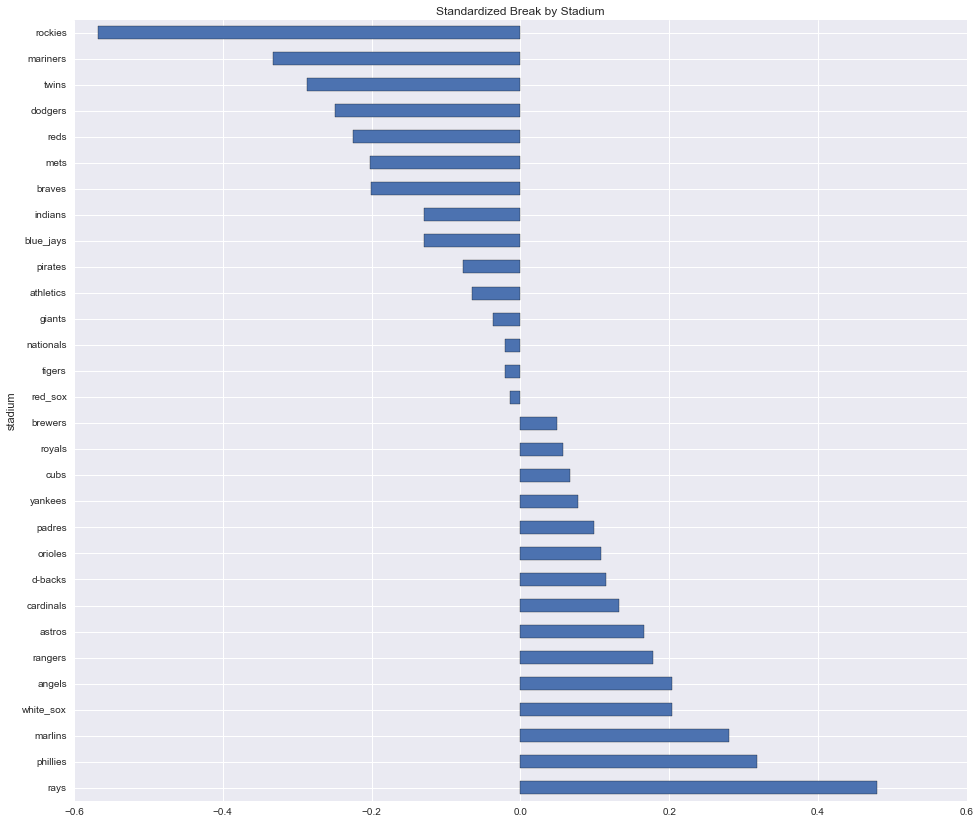

In [46]:

stadium_df = pd.DataFrame(within_pitcher.groupby('stadium')[['break_total', 'break_zscore', 'altitude']].mean())


stadium_df.sort('break_zscore' ,ascending = False)['break_zscore'].plot(kind = 'barh', figsize = (16,14), title = 'Standardized Break by Stadium')


here is the distribution of pitch break by stadium in histogram form. Pretty normally distributed.

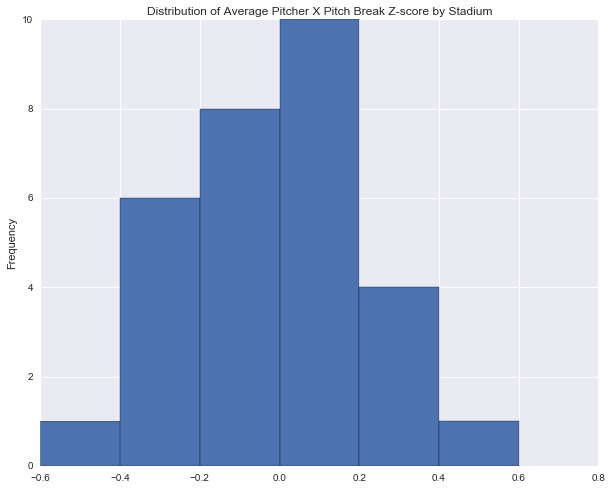

In [47]:
stadium_df['break_zscore'].plot(kind = 'hist', bins = np.linspace(-.6,.6,7),figsize = (10,8), title = "Distribution of Average Pitcher X Pitch Break Z-score by Stadium")

#### Is frequency of home rotation a confounding factor?

Createed dataframe of mean pitch break by home vs away

In [48]:
home_away = pd.DataFrame(within_pitcher[within_pitcher.inning_topbot == 'bot'].groupby('stadium')['break_zscore'].mean())
home_away.rename(columns = {'break_zscore': 'just_away'}, inplace = True)
home_away['just_home'] = pd.DataFrame(within_pitcher[within_pitcher.inning_topbot == 'top'].groupby('stadium')['break_zscore'].mean())
home_away['combined'] = pd.DataFrame(within_pitcher.groupby('stadium')['break_zscore'].mean())
home_away.head()

,just_away,just_home,combined
stadium,,,
angels,0.291724,0.120660,0.203261
astros,0.198752,0.135788,0.166783
athletics,-0.074913,-0.054505,-0.064552
blue_jays,-0.136211,-0.121208,-0.128863
braves,-0.266347,-0.138835,-0.200840


.94 correlation. nice!

In [49]:
home_away.corr()

,just_away,just_home,combined
just_away,1.000000,0.948489,0.993549
just_home,0.948489,1.000000,0.978267
combined,0.993549,0.978267,1.000000


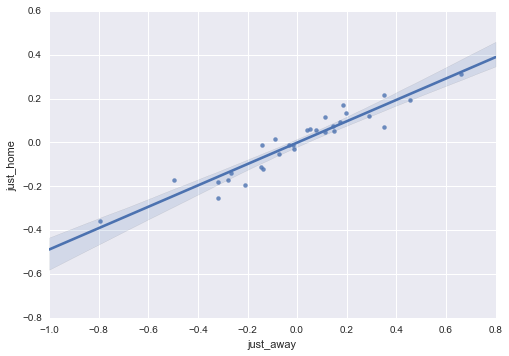

In [50]:
sns.regplot(x = home_away.just_away, y = home_away.just_home, ci = 95)

### The impact of stadium elevation

Lets look at just altitude

In [51]:
stadium_df.altitude.describe()

count      30.000000
mean      517.600000
std       944.560602
min         9.000000
25%        42.500000
50%       257.000000
75%       611.000000
max      5183.000000
Name: altitude, dtype: float64

Colorado is a massive outlier. Everywhere else is below 1,500 feet!
Was not expecting there to be such little variation in elevation outside Colorado.
Might hamper this analysis. 

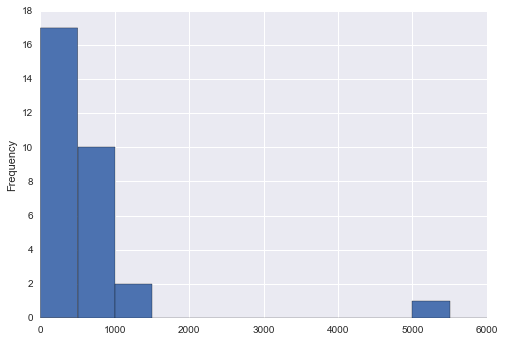

In [52]:
stadium_df.altitude.plot(kind = 'hist', bins = np.linspace(0,6000,13))

## Pitch break and altitude by pitch type

Let's do a scatter plot of the mean break for all pitches by stadium elevation.
Well, there is clearly much less pitch break in Colorado, but no so sure about everywhere else

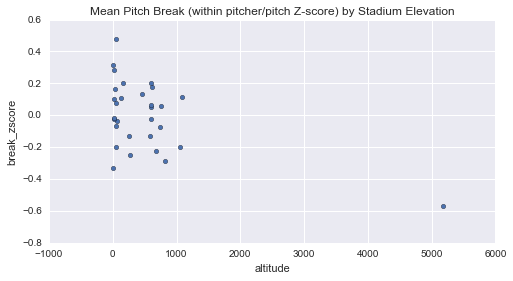

In [53]:
stadium_df.plot(x = 'altitude', y = 'break_zscore', kind = 'scatter',figsize = (8,4), title = 'Mean Pitch Break (within pitcher/pitch Z-score) by Stadium Elevation')
plt.savefig('elevation_break_scatter.png')

Let's do the same graph, but zoom in on the blob to the left
There is kind of a negative trend?

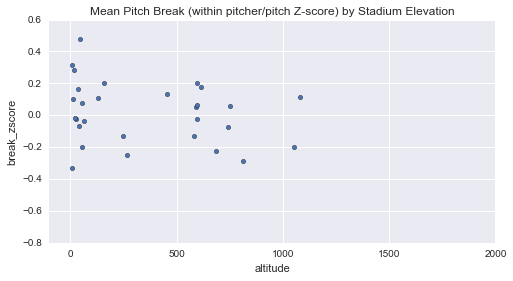

In [54]:
stadium_df.plot(x = 'altitude', y = 'break_zscore', kind = 'scatter',figsize = (8,4), xlim = (-100, 2000),title = 'Mean Pitch Break (within pitcher/pitch Z-score) by Stadium Elevation')
plt.savefig('elevation_break_scatter2.png')

Maybe to find the really significant findings we need to break out the dateset by pitchtype
and analyze each pitch independently even though we are already using within pitcher/pitch zscore.

Remember the Magnus effect graph from above? Pitch type mattered!

what are our pitches again? list in order of commonness

In [55]:
within_pitcher.pitch_type.value_counts()

FF    253156
SL    102011
FT     95048
CH     72356
CU     54630
SI     50065
FC     36893
KC     14531
FS     10823
KN      3717
IN      3131
FA      2603
FO       380
EP       328
PO       234
UN        30
SC         5
AB         4
Name: pitch_type, dtype: int64

Let's add the mean break for these pitches to our stadium dataframe
but ignore the fake (intentional walks for example) and very uncommon pitches

In [56]:

ignore_pitches = ['IN','PO','EP', 'FO','UN','AB','KN','FA','SC']

for pitch in within_pitcher.pitch_type.unique():
    if pitch in ignore_pitches:
        continue
    stadium_df[pitch] = within_pitcher[within_pitcher.pitch_type == pitch].groupby('stadium')['break_zscore'].mean()

In [57]:
# There they are! handsome devils.
stadium_df.head()

,break_total,break_zscore,altitude,FF,FT,SL,CH,CU,FC,SI,KC,FS
stadium,,,,,,,,,,,,
angels,9.585644,0.203261,160,0.419493,0.423597,-0.150978,0.255967,-0.282374,0.075346,0.271110,-0.258666,0.282038
astros,9.285567,0.166783,38,0.015399,0.362457,0.359230,0.069331,0.406296,0.351504,-0.245511,0.219823,-0.579734
athletics,9.091999,-0.064552,42,-0.090718,-0.178557,0.030392,-0.107084,0.049573,-0.062790,-0.073939,0.341532,0.230154
blue_jays,8.801664,-0.128863,247,-0.166659,-0.042791,-0.335221,-0.060447,0.031493,-0.281982,-0.103506,-0.207566,0.358570
braves,8.648319,-0.200840,1050,-0.257041,-0.166042,-0.230308,-0.096129,-0.150417,-0.309512,-0.122610,-0.056447,-0.263100


Here is the correlation between altitude and all of those pitches

In [58]:
stadium_df.corr()

,break_total,break_zscore,altitude,FF,FT,SL,CH,CU,FC,SI,KC,FS
break_total,1.000000,0.912509,-0.574555,0.859110,0.867596,0.526736,0.827022,0.112890,0.711733,0.720040,0.252586,0.392562
break_zscore,0.912509,1.000000,-0.533096,0.952198,0.938426,0.534368,0.915876,0.079302,0.800057,0.794800,0.182890,0.482578
altitude,-0.574555,-0.533096,1.000000,-0.371215,-0.475816,-0.337359,-0.513011,-0.600425,-0.253624,-0.371595,-0.713363,-0.429074
FF,0.859110,0.952198,-0.371215,1.000000,0.929006,0.336694,0.920596,-0.205206,0.750647,0.846713,-0.075879,0.527407
FT,0.867596,0.938426,-0.475816,0.929006,1.000000,0.307952,0.959159,-0.081649,0.658158,0.818347,0.029707,0.452320
SL,0.526736,0.534368,-0.337359,0.336694,0.307952,1.000000,0.217609,0.566830,0.747122,0.029512,0.546815,-0.138311
CH,0.827022,0.915876,-0.513011,0.920596,0.959159,0.217609,1.000000,-0.107185,0.554108,0.863575,0.048252,0.549674
CU,0.112890,0.079302,-0.600425,-0.205206,-0.081649,0.566830,-0.107185,1.000000,0.112005,-0.252781,0.916160,-0.063170
FC,0.711733,0.800057,-0.253624,0.750647,0.658158,0.747122,0.554108,0.112005,1.000000,0.381451,0.147859,0.092509
SI,0.720040,0.794800,-0.371595,0.846713,0.818347,0.029512,0.863575,-0.252781,0.381451,1.000000,-0.121601,0.700966


Turn the correlation matrix into a dataframe for further analysis and sort by altitude column, so the pitches with the strongest negative correlation are on top

In [59]:
pitch_corr = pd.DataFrame(stadium_df.corr())
pitch_corr.drop(['altitude','break_zscore','break_total'], axis = 0, inplace = True)
pitch_corr.sort('altitude')

/Users/pyvarjan/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


,break_total,break_zscore,altitude,FF,FT,SL,CH,CU,FC,SI,KC,FS
KC,0.252586,0.182890,-0.713363,-0.075879,0.029707,0.546815,0.048252,0.916160,0.147859,-0.121601,1.000000,0.004399
CU,0.112890,0.079302,-0.600425,-0.205206,-0.081649,0.566830,-0.107185,1.000000,0.112005,-0.252781,0.916160,-0.063170
CH,0.827022,0.915876,-0.513011,0.920596,0.959159,0.217609,1.000000,-0.107185,0.554108,0.863575,0.048252,0.549674
FT,0.867596,0.938426,-0.475816,0.929006,1.000000,0.307952,0.959159,-0.081649,0.658158,0.818347,0.029707,0.452320
FS,0.392562,0.482578,-0.429074,0.527407,0.452320,-0.138311,0.549674,-0.063170,0.092509,0.700966,0.004399,1.000000
SI,0.720040,0.794800,-0.371595,0.846713,0.818347,0.029512,0.863575,-0.252781,0.381451,1.000000,-0.121601,0.700966
FF,0.859110,0.952198,-0.371215,1.000000,0.929006,0.336694,0.920596,-0.205206,0.750647,0.846713,-0.075879,0.527407
SL,0.526736,0.534368,-0.337359,0.336694,0.307952,1.000000,0.217609,0.566830,0.747122,0.029512,0.546815,-0.138311
FC,0.711733,0.800057,-0.253624,0.750647,0.658158,0.747122,0.554108,0.112005,1.000000,0.381451,0.147859,0.092509


So the pitches with the strongest negative correlation between altitude and mean z_score break are your 
classic breaking (slow) pitches - Curveball, Knuckle Curve, and Change up

/Users/pyvarjan/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


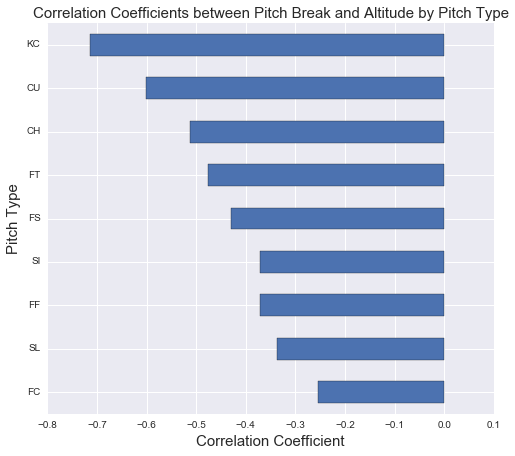

In [60]:
graph = pitch_corr.sort('altitude',ascending = False).altitude.plot(kind = 'barh', figsize = (8,7))
graph.set_ylabel('Pitch Type')
graph.set_xlabel('Correlation Coefficient')
graph.set_title('Correlation Coefficients between Pitch Break and Altitude by Pitch Type')
graph.title.set_fontsize(15)
graph.xaxis.label.set_fontsize(15)
graph.yaxis.label.set_fontsize(15)
#graph.set_yticklabels(['Cutter','Fastball','Split-Finger','Slider','Sinker','Four-Seam','Two-Seam','Changeup','Curveball','Knuckle-Curve'])
plt.savefig('elevation_pitch_correlation.png')

Scatter plot for the knuckle curve

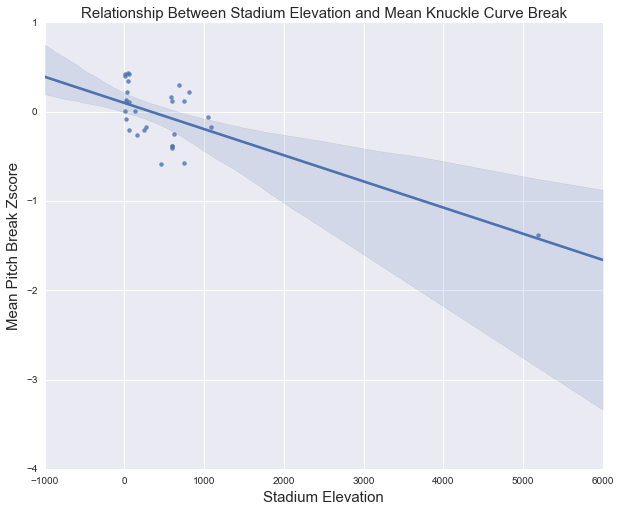

In [61]:
dims = (10, 8)
fig, ax = plt.subplots(figsize=dims)
graph = sns.regplot(x = stadium_df.altitude, y = stadium_df.KC)
graph.set_ylabel('Mean Pitch Break Zscore')
graph.set_xlabel('Stadium Elevation')
graph.set_title('Relationship Between Stadium Elevation and Mean Knuckle Curve Break')
graph.title.set_fontsize(15)
graph.xaxis.label.set_fontsize(15)
graph.yaxis.label.set_fontsize(15)
plt.savefig('KC_regplot.png')

Scatter plot for the curve ball

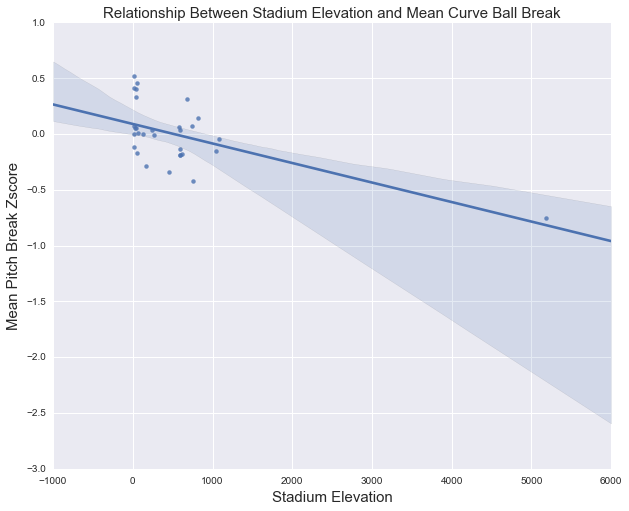

In [62]:
dims = (10, 8)
fig, ax = plt.subplots(figsize=dims)
graph = sns.regplot(x = stadium_df.altitude, y = stadium_df.CU)
graph.set_ylabel('Mean Pitch Break Zscore')
graph.set_xlabel('Stadium Elevation')
graph.set_title('Relationship Between Stadium Elevation and Mean Curve Ball Break')
graph.title.set_fontsize(15)
graph.xaxis.label.set_fontsize(15)
graph.yaxis.label.set_fontsize(15)

## Other Weather Factors and Pitch Break

### Temperature

Lets look at how temperature relates to pitch break.
First, we will create some bins:

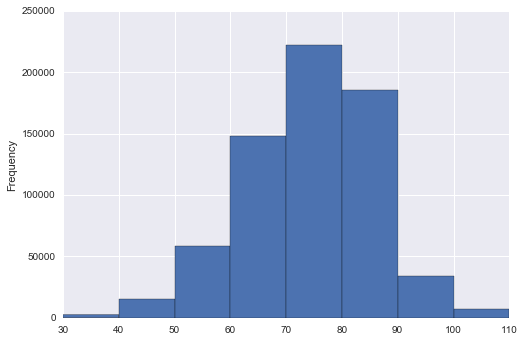

In [63]:
ranges = np.linspace(30,110,9)
within_pitcher['tempF_bin'] = pd.cut(within_pitcher.tempF, ranges).astype('category')
within_pitcher.tempF.plot(kind = 'hist', bins = np.linspace(30,110,9))

Very nice distribution of temperatures unlike elevation, which should lend itself nicely to analysis.

When doing this analysis, we will exclude all those stadiums that have roofs since we don't know their internal temp.

The plot below displays the mean with confidence intervals of overall pitchbreak by temperature bin. 

Beautiful and tight negative trend. This makes sense regarding the Magnus effect because the molecules in warm air are more spaced out resulting in less force enacted on the ball.


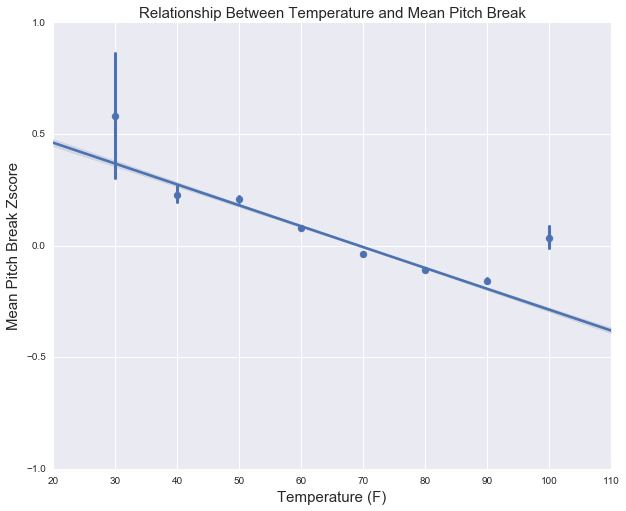

In [64]:
dims = (10, 8)
fig, ax = plt.subplots(figsize=dims)
selection = within_pitcher[within_pitcher.isclosable == False]
graph = sns.regplot(x = selection.tempF, y = selection.break_zscore, x_bins = ranges, ci = 99)
graph.set_ylabel('Mean Pitch Break Zscore')
graph.set_ylim(-1,1)
graph.set_xlabel('Temperature (F)')
graph.set_title('Relationship Between Temperature and Mean Pitch Break')
graph.title.set_fontsize(15)
graph.xaxis.label.set_fontsize(15)
graph.yaxis.label.set_fontsize(15)
plt.savefig('graph_temp.png')

### Relative Humidity

Let's do the exact same process we did with temperature but with relative humidity, aka bin it then analyze it

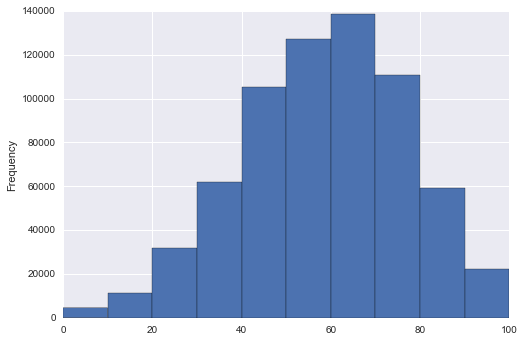

In [65]:
ranges = np.linspace(30,110,9)
within_pitcher['relhum_bin'] = pd.cut(within_pitcher.relhum, ranges).astype('category')
within_pitcher.relhum.plot(kind = 'hist', bins = np.linspace(0,100,11))

Nice variation in humidity.

The plot below shows us that there is a very, very slight positive relationship between relative humidity and pitch break. Practically nothing

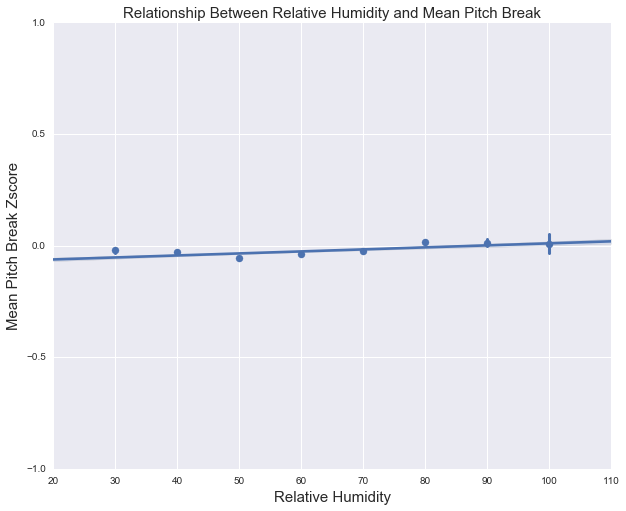

In [66]:
dims = (10, 8)
fig, ax = plt.subplots(figsize=dims)
selection = within_pitcher[within_pitcher.isclosable == False]
graph = sns.regplot(x = selection.relhum, y = selection.break_zscore, x_bins = ranges, ci = 99)
graph.set_ylabel('Mean Pitch Break Zscore')
graph.set_ylim(-1,1)
graph.set_xlabel('Relative Humidity')
graph.set_title('Relationship Between Relative Humidity and Mean Pitch Break')
graph.title.set_fontsize(15)
graph.xaxis.label.set_fontsize(15)
graph.yaxis.label.set_fontsize(15)
plt.savefig('graph_humdidity.png')

### Barometric Pressure

Barometric pressure is an especially important variable in this analysis because it is negatively associated with elevation. Hopefully it will confirm what we found with stadium elevation

Bin it and analyze!

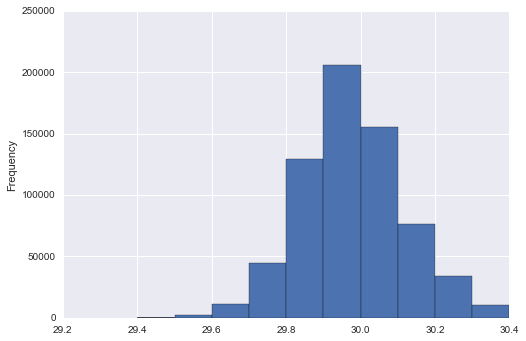

In [67]:
ranges = np.linspace(29.4,30.4,11)
within_pitcher['altibarom_bin'] = pd.cut(within_pitcher.altibarom, ranges).astype('category')
within_pitcher.altibarom.plot(kind = 'hist', bins = np.linspace(29.4,30.4,11))

There exists a modest positive relationship between barometric pressure and pitch break (plot below).

This supports our hypothesis that the thin air at high altitudes reduces the break of pitches since barometric pressure decreases as elevation increases.

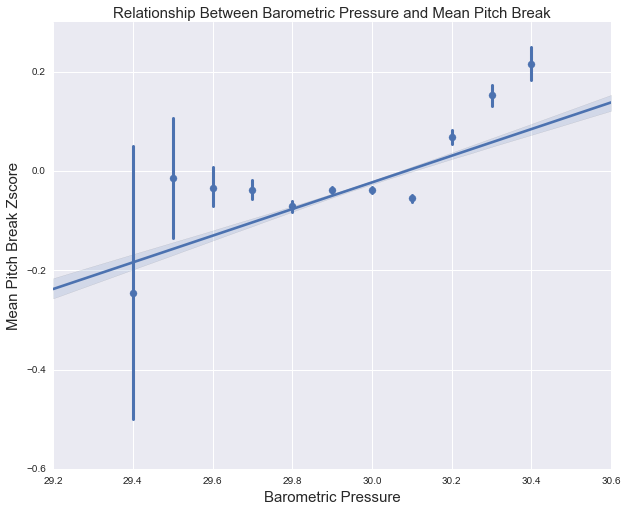

In [68]:
dims = (10, 8)
fig, ax = plt.subplots(figsize=dims)
selection = within_pitcher[within_pitcher.isclosable == False]
graph = sns.regplot(x = selection.altibarom, y = selection.break_zscore, x_bins = ranges, ci = 99)
graph.set_ylabel('Mean Pitch Break Zscore')
graph.set_xlabel('Barometric Pressure')
graph.set_title('Relationship Between Barometric Pressure and Mean Pitch Break')
graph.title.set_fontsize(15)
graph.xaxis.label.set_fontsize(15)
graph.yaxis.label.set_fontsize(15)
plt.savefig('graph_baro.png')